<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/modeling_WESAD_all_subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Wearable Device Data

In this section, we'll build and evaluate a deep learning models to predict if someone is in a state of stress or not based on data from a wearable device. We'll be using a combination of fully connected, LSTM, CNN, and Transformer layers in our model to capture the sequential nature of the data and the long-term dependencies within it. The final output of our model will be a probability between 0 and 1, where values closer to 1 indicate a higher likelihood of stress.

##  Objective Review
Our company, HealthOn, produces wearable device technology that records a users physiological data and gives them recommendations to improve their health. We want to create a way to reduce our user's stress and want to forecast when they will be in a stressful state in the next 5 minutes.

## Preprocessed Data EDA

### About the data

The data being used in this section is the preprocessed data where specific features from the physiological data has been extracted. Further statistical features will be extracted to produce the final dataset for model fitting.

- Download the [preprocessed data](https://drive.google.com/file/d/1KuIc5ypFB30McV7tl3ziwQndEIjvtgBJ/view?usp=share_link)(1.81GB) stored in a pickle (.pkl) file.
- Save in a Google Drive directory called `stress-prediction`
- Run the code below to load the data. What it does:
  - Mount Google Drive with the downloaded pre-processed data into a folder `stress-prediction`. We can access the data stored in your Google Drive
  - Set the working directory to the root folder of our project on Google Drive
  - Load the pickled data using joblib

After loading the data, this notebook will prepare the data for modeling by splitting it into training, validation, and testing sets, and then normalize the data to ensure that our model is able to learn from it effectively. We'll also use a class weight to give the minority class a weight boost to address class imbalance.

Finally, we'll train and evaluate our model on the testing set and compute various metrics such as accuracy, precision, recall, and F1-score to measure its performance.

In [13]:
# Import required libraries
import os
import pickle
import joblib

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change working directory to the main file directory on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')

# Define the path of the data directory on Google Drive
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data')

# Load the pickled data using joblib
data = joblib.load(f"{PATH}/pickle/WESAD_model_data.pickle")

Mounted at /content/drive


# Exploratory Data Analysis
Now that we have loaded our pickled data, let's take a look at its structure. The 'data' variable is a list of two elements: a pandas dataframe and a numpy array.We can access the dataframe using `data[0]`. To get information about the the first subject's preprocessed data.



In [14]:
# Structure of single dataframe in the list
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [17]:
# Find the size and length of each dataframe
import pandas as pd

# Calculate duration of each dataframe in minutes
for i, df in enumerate(data):
    duration = len(df) / (700 * 60)
    df['duration'] = duration
    
# Create a table showing the duration of each dataframe
df_lengths = pd.DataFrame({'Subject': [f"{i}" for i in range(len(data))],
                           'Observations': [len(df) for df in data],
                           '(min)': [round(df['duration'][0]) for df in data]})
#print(df_lengths.to_string(index=False))
df_lengths

,Subject,Observations,(min)
0,0,3847200,92
1,1,3883600,92
2,2,3875900,92
3,3,3663100,87
4,4,3941700,94
5,5,3676400,88
6,6,4144000,99
7,7,4255300,101
8,8,4545100,108
9,9,4496100,107


In [12]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
 5   duration    float64
dtypes: float32(1), float64(4), int32(1)
memory usage: 146.8 MB


## Feature Engineering
We will compute statistical features that capture the patterns in the data that are relevant to predicting stress. Specifically, we will compute the mean and standard deviation of EDA over different time intervals using a rolling window function.

To compute these features, we define a function called `compute_features`. This function takes as input a dataframe and a list of columns to exclude from feature computation. It computes rolling mean and standard deviation features for all columns except those in the exclude_cols list. We define two window sizes, 60 seconds and 300 seconds, which correspond to intervals of one and five minutes, respectively.

We apply the `compute_features` function to each dataframe in the list using a list comprehension, creating a new list of dataframes with the computed features. Finally, we drop any rows with missing values in the resulting dataframes to prepare them for modeling.

In [18]:
# Define a function to compute mean, standard deviation of past 1 and 5 min
def compute_features(df, Hz_sampled, exclude_cols=[]):
    # Create a copy of the input DataFrame
    df = df.copy()

    # Compute rolling mean and standard deviation features for all columns
    # except those in exclude_cols
    windows = [int(60 * Hz_sampled), int(300 * Hz_sampled)]

    for col in df.columns:
        if col not in exclude_cols:
            for window in windows:
                df[f'{col}_mean_{window // Hz_sampled}s'] = df[col].rolling(window=window).mean()
                df[f'{col}_std_{window // Hz_sampled}s'] = df[col].rolling(window=window).std()

    # Drop rows with missing values
    df.dropna(inplace=True)
    return df

# Apply the function to each dataframe in the list
data_frames_list = [compute_features(df, 700, ['label', 'duration']) for df in data]


In [19]:
def trim_and_chop(df, Hz_sampled, duration):
    """
    Trim the length of each subject dataframe to be divisible by 
    the desired sequence length, and remove any excess rows.
    
    Args:
    df (DataFrame): The subject's raw dataframe
    Hz_sampled (int): The frequency of the data
    duration (int): The desired duration of each sequence in seconds

    Returns:
    df_trimmed (DataFrame): The trimmed dataframe
    """
    # Calculate the desired length of each sequence
    target_length = Hz_sampled * duration
    
    # Check if the length of the dataframe is already divisible by the target length
    remainder = len(df) % target_length

    if remainder != 0:
        # Calculate the number of rows to trim from the top and bottom
        top_trim = remainder // 2
        bottom_trim = remainder - top_trim

        # Trim the dataframe
        df_trimmed = df.iloc[top_trim: -bottom_trim]
        return df_trimmed
    else:
        return df

trimmed_df_list = [trim_and_chop(df, 700, (5*60)) for df in data_frames_list]

In [20]:
# Display all the new features
trimmed_df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3570000 entries, 243599 to 3813598
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   RSP_Rate              float64
 1   EDA_Phasic            float64
 2   ECG_Rate              float64
 3   Temp                  float32
 4   label                 int32  
 5   duration              float64
 6   RSP_Rate_mean_60s     float64
 7   RSP_Rate_std_60s      float64
 8   RSP_Rate_mean_300s    float64
 9   RSP_Rate_std_300s     float64
 10  EDA_Phasic_mean_60s   float64
 11  EDA_Phasic_std_60s    float64
 12  EDA_Phasic_mean_300s  float64
 13  EDA_Phasic_std_300s   float64
 14  ECG_Rate_mean_60s     float64
 15  ECG_Rate_std_60s      float64
 16  ECG_Rate_mean_300s    float64
 17  ECG_Rate_std_300s     float64
 18  Temp_mean_60s         float64
 19  Temp_std_60s          float64
 20  Temp_mean_300s        float64
 21  Temp_std_300s         float64
dtypes: float32(1), float64(20), int32(1)


In [21]:
trimmed_df_list[0].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
RSP_Rate,3570000.0,1.461197e+01,5.467430e+00,2.319673,10.168142,1.500523e+01,18.249221,51.660517
EDA_Phasic,3570000.0,1.652568e-06,5.241135e-03,-0.055904,-0.001296,-6.506017e-05,0.001155,0.092057
ECG_Rate,3570000.0,9.173783e+01,1.577418e+01,53.915276,79.151481,9.108286e+01,102.182506,152.727273
Temp,3570000.0,3.482161e+01,4.541593e-01,34.136749,34.414764,3.464474e+01,35.306641,35.778046
label,3570000.0,1.421569e-01,3.492110e-01,0.000000,0.000000,0.000000e+00,0.000000,1.000000
duration,3570000.0,9.160000e+01,7.389645e-13,91.600000,91.600000,9.160000e+01,91.600000,91.600000
RSP_Rate_mean_60s,3570000.0,1.463973e+01,3.476750e+00,5.527036,12.206068,1.526531e+01,17.405408,22.693054
RSP_Rate_std_60s,3570000.0,3.843627e+00,1.723224e+00,0.875032,2.514544,3.613787e+00,4.842836,9.056521
RSP_Rate_mean_300s,3570000.0,1.478697e+01,2.597034e+00,7.838479,13.046097,1.558837e+01,17.080891,18.760963
RSP_Rate_std_300s,3570000.0,4.612333e+00,1.121828e+00,2.299659,3.677238,4.585956e+00,5.536561,7.192086


In [22]:
trimmed_df_list[0].head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label,duration,RSP_Rate_mean_60s,RSP_Rate_std_60s,RSP_Rate_mean_300s,RSP_Rate_std_300s,...,EDA_Phasic_mean_300s,EDA_Phasic_std_300s,ECG_Rate_mean_60s,ECG_Rate_std_60s,ECG_Rate_mean_300s,ECG_Rate_std_300s,Temp_mean_60s,Temp_std_60s,Temp_mean_300s,Temp_std_300s
243599,17.250649,-0.001230,87.339712,34.286285,0,91.6,18.117939,1.166209,17.439459,3.793102,...,3.911796e-07,0.001617,94.814792,6.049363,96.764945,6.999736,34.288191,0.031857,34.087082,0.162913
243600,17.251090,-0.001206,87.354605,34.316895,0,91.6,18.117877,1.166186,17.439435,3.793087,...,3.857990e-07,0.001617,94.814308,6.049146,96.764877,6.999758,34.288193,0.031857,34.087084,0.162912
243601,17.251531,-0.001181,87.369520,34.309235,0,91.6,18.117816,1.166164,17.439410,3.793072,...,3.805120e-07,0.001617,94.813824,6.048929,96.764808,6.999779,34.288195,0.031855,34.087087,0.162912
243602,17.251972,-0.001157,87.384458,34.316895,0,91.6,18.117754,1.166142,17.439386,3.793057,...,3.753225e-07,0.001617,94.813341,6.048712,96.764740,6.999801,34.288196,0.031856,34.087090,0.162911
243603,17.252413,-0.001132,87.399418,34.280182,0,91.6,18.117693,1.166120,17.439362,3.793041,...,3.702344e-07,0.001617,94.812858,6.048495,96.764672,6.999822,34.288198,0.031852,34.087092,0.162910


In [23]:
## Include Subject for each dataframe to prepare for concatenation
for i, df in enumerate(trimmed_df_list):
    # Set subject as categorical
    df['subject'] = i
    df['subject'] = df['subject'].astype('category')

<ipython-input-23-8a1fec3feffd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject'] = i
<ipython-input-23-8a1fec3feffd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject'] = df['subject'].astype('category')
<ipython-input-23-8a1fec3feffd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

## Modeling Data Generation

### Train-Test Split
We are splitting our dataset into training, validation, and testing sets. We are concatenating all of the dataframes together, down-sampling the data to a target frequency of 1Hz, and dropping any columns that have any missing values.

Then, we are splitting the data into training, validation, and testing sets by subject. This is important to ensure that we have a balanced distribution of subjects in each dataset. We are using a 60:20:20 split, where 60% of the subjects are in the training set, 20% are in the validation set, and 20% are in the testing set.

We are standardizing the data using a StandardScaler object, which scales the data to have a mean of 0 and a standard deviation of 1. This is important to ensure that all of the features are on the same scale and that no one feature dominates the others.

Finally, we are converting the subject column to a categorical variable, which is required for training the model with the fit method.

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Concatenate the dataframes together
df = pd.concat(trimmed_df_list)

# Downsample the dataframe
sample_hz = 700
target_hz = 1
resample_factor = int(sample_hz / target_hz)
df = df.iloc[::resample_factor, :]

# Drop any columns that have any missing values
df = df.dropna(axis=1, how='any')

# Split the data into training, testing, and validation sets by subject
train_dfs = []
test_dfs = []
val_dfs = []

# Define the percentage split for training, validation, and testing data
train_pct = 0.6
val_pct = 0.2
test_pct = 0.2

# Get a list of unique subject IDs
subject_ids = np.unique(df['subject'])

# Randomly shuffle the subject IDs
np.random.shuffle(subject_ids)

# Calculate the number of subjects for each dataset
num_train = int(len(subject_ids) * train_pct)
num_val = int(len(subject_ids) * val_pct)
num_test = int(len(subject_ids)) - num_train - num_val

# Split the subject IDs into training, validation, and testing sets
train_subjects = subject_ids[:num_train]
val_subjects = subject_ids[num_train:num_train+num_val]
test_subjects = subject_ids[num_train+num_val:]

# Split the data into training, validation, and testing sets by subject ID
train_df = df[df['subject'].isin(train_subjects)]
val_df = df[df['subject'].isin(val_subjects)]
test_df = df[df['subject'].isin(test_subjects)]

# Standardize the data
scaler = StandardScaler()
cols_to_transform = [col for col in train_df.columns if col not in ['subject', 'label']]
train_df[cols_to_transform] = scaler.fit_transform(train_df[cols_to_transform])
test_df[cols_to_transform] = scaler.transform(test_df[cols_to_transform])
val_df[cols_to_transform] = scaler.transform(val_df[cols_to_transform])

# Set subject as categorical
train_df['subject'] = train_df['subject'].astype('category')
test_df['subject'] = test_df['subject'].astype('category')
val_df['subject'] = val_df['subject'].astype('category')

<ipython-input-25-83e5962d0681>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[cols_to_transform] = scaler.fit_transform(train_df[cols_to_transform])
<ipython-input-25-83e5962d0681>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[cols_to_transform] = scaler.transform(test_df[cols_to_transform])
<ipython-input-25-83e5962d0681>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48900 entries, 243599 to 3612349
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   RSP_Rate              48900 non-null  float64 
 1   EDA_Phasic            48900 non-null  float64 
 2   ECG_Rate              48900 non-null  float64 
 3   Temp                  48900 non-null  float64 
 4   label                 48900 non-null  int32   
 5   duration              48900 non-null  float64 
 6   RSP_Rate_mean_60s     48900 non-null  float64 
 7   RSP_Rate_std_60s      48900 non-null  float64 
 8   RSP_Rate_mean_300s    48900 non-null  float64 
 9   RSP_Rate_std_300s     48900 non-null  float64 
 10  EDA_Phasic_mean_60s   48900 non-null  float64 
 11  EDA_Phasic_std_60s    48900 non-null  float64 
 12  EDA_Phasic_mean_300s  48900 non-null  float64 
 13  EDA_Phasic_std_300s   48900 non-null  float64 
 14  ECG_Rate_mean_60s     48900 non-null  float64 


In [27]:
# Display which subjects are in which dataset group
print(train_df['subject'].unique())
print(val_df['subject'].unique())
print(test_df['subject'].unique())

[0, 2, 3, 7, 8, 9, 11, 12, 14]
Categories (9, int64): [0, 2, 3, 7, ..., 9, 11, 12, 14]
[1, 5, 6]
Categories (3, int64): [1, 5, 6]
[4, 10, 13]
Categories (3, int64): [4, 10, 13]


In [28]:
# Total length of each dataset. Since validation and test datasets
# have less subjects, they will have less observations
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(48900, 23)
(15300, 23)
(15900, 23)


### Label Class Imbalance
Class imbalance is a problem in machine learning where the distribution of classes in the training data is not balanced. In some cases, one class may have significantly fewer samples than the other. This can lead to a model that is biased towards the majority class and performs poorly on the minority class.

To address this issue, we can use class weight correction. Class weight correction assigns a weight to each class based on its frequency in the training data. The weight is higher for the minority class and lower for the majority class. This way, the model is encouraged to pay more attention to the minority class during training.

In this code section, we first check the balance of the two label cases (0 is neutral and 1 is stress) in our training data. We find that there is a class imbalance as the number of stress samples is significantly smaller than the number of non-stress samples.

We calculate the class weights by passing the training labels to the `compute_sample_weight` function and setting the `class_weight` parameter to `'balanced'`. This computes the weight for each class based on the inverse of its frequency in the training data.

Next, we define a dictionary that maps each class label to its corresponding weight. We set the weight for the minority (stress) class to be higher than the majority (non-stress) class.

Finally, we plot a bar graph to visualize the class imbalance in our training data. We can see that the stress class has significantly fewer samples than the non-stress class.

In [29]:
# Balance of the two label cases. 0 is neutral and 1 is stress
# Indicates class imbalance
train_df['label'].value_counts()

0    43006
1     5894
Name: label, dtype: int64

Class 0 (Non-stress): 87.95%
Class 1 (Stress): 12.05%


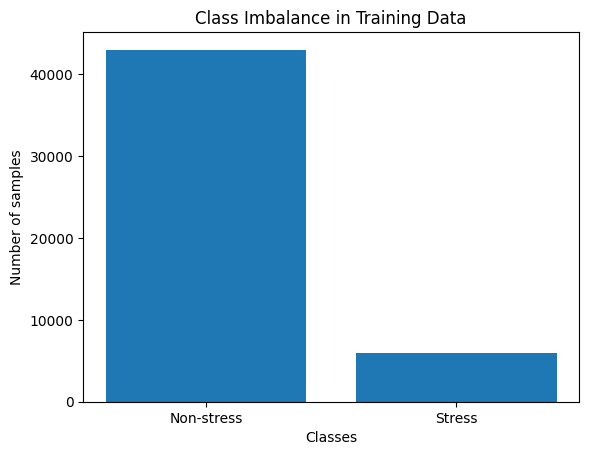

In [30]:
# Class weight correction
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np

y_train = train_df['label']

# Calculate class counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_percentages = (class_counts / class_counts.sum()) * 100

# Define class weight dictionary
zero_count = class_counts[0]
one_count = class_counts[1]
class_weights_dict = {0: 1 / zero_count, 1: 1 / one_count}

# Print class percentages
for class_id, percentage in zip(unique_classes, class_percentages):
    print(f"Class {class_id} ({'Non-stress' if class_id == 0 else 'Stress'}): {percentage:.2f}%")

# Create a bar plot for class counts
plt.bar(unique_classes, class_counts, tick_label=['Non-stress', 'Stress'])
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Imbalance in Training Data')
plt.show()

## Data Generator
The data generated from previous processing steps are structured to be fed into a neural network model. This is done using the `TimeseriesGenerator` class from the `keras` preprocessing module. The data is first divided into batches, with each batch containing a fixed number of sequences of a fixed length. The sequence length is determined based on the desired duration of the time series (in minutes), the sample frequency, and the target sequence length (in rows). For each set, the data is trimmed at the beginning and end to ensure that only full-length sequences are included.

Finally, the `TimeseriesGenerator` class is used to create a generator object for each set of data. The generator object iteratively returns batches of sequence data and corresponding labels, with the start index of each sequence in the batch determined by the generator based on the specified sequence length and stride.

The `TimeseriesGenerator` creates sequences of fixed length from the input data, with each sequence overlapping with the previous one by a certain amount. This overlap is controlled by the stride parameter.Stride refers to the number of rows to move forward between each sequence generated by the `TimeseriesGenerator`.

Here, `stride` is set to 1 minute, which means that each sequence in the generator will be 5 minutes long (the duration parameter), and will start 1 minute after the previous one ended. This means that each sequence in the generator will overlap with the previous one by 4 minutes.

Using a stride like this can help capture more information from the data, since each sequence will contain some data that was also present in the previous sequence.

In [31]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define batch size and sequence length
duration = 5 # minutes
batch_size = 10
seq_length = target_hz * 60 * duration # full length of sequence

# Calculate the offset in rows
offset_minutes = 5
offset_rows = offset_minutes * target_hz * 60 # seconds

# Stride
stride = 1 * target_hz * 60 # 1 minute strides

# Extract values from DataFrame
train_data = train_df.drop(['label', 'subject', 'duration'], axis=1).values
val_data = val_df.drop(['label', 'subject', 'duration'], axis=1).values
test_data = test_df.drop(['label', 'subject', 'duration'], axis=1).values

# Trim front and end of the data
train_data = train_data[:-seq_length]
train_labels = train_df['label'][seq_length:].values
val_data = val_data[:-seq_length]
val_labels = val_df['label'][seq_length:].values
test_data = test_data[:-seq_length]
test_labels = test_df['label'][seq_length:].values

# Create data generators with start_index
train_gen = TimeseriesGenerator(train_data, 
                                train_labels,
                                length=seq_length, 
                                batch_size=batch_size, 
                                shuffle=False)

val_gen = TimeseriesGenerator(val_data, 
                              val_labels,
                              length=seq_length, 
                              batch_size=batch_size)

test_gen = TimeseriesGenerator(test_data, 
                               test_labels,
                               length=seq_length, 
                               batch_size=batch_size)

In [32]:
# Display the shape of train_gen, val_gen, and test_gen
data_shape = train_gen[0][0].shape
print(data_shape)

(10, 300, 20)


#### Data Generator Shape
The shape (10, 300, 20) indicates a 3-dimensional tensor with 10 samples, each sample containing a sequence of 300 timesteps and 20 features per timestep. This means that the data is organized as 10 sequences, where each sequence is a segment of 300 timesteps with 20 features per timestep. This format is suitable for input to neural network models that expect sequential data with a fixed number of timesteps and features per timestep. The batch size of 10 means that 10 sequences are processed in parallel during training, which can help improve training efficiency and convergence.

## Modeling
We will explore different machine learning models, including 6 neural network models, a Random Forest model, and an XGBoost model, to predict stress based on time series data. Time series data can be challenging to model due to its sequential nature and the need to capture temporal dependencies. Therefore, we will focus on using neural networks, which have proven to be effective in modeling time series data. Neural networks are capable of automatically learning relevant features and patterns from the data, which can be used to make accurate predictions.

In [33]:
# Define helper function to plot the training and validation accuracy and loss
def plot_evaluation(model, file_name):
    '''
    Plots the Training and validation accuracy as well as the training and validation loss
    over the number of epochs specified.

    Args:
    model: history object returned from the fit() method of the Keras model
    file_name: filename to save the plot

    Returns:
    None
    '''
    # Import necessary libraries
    import matplotlib.pyplot as plt
    
    # Get training and validation accuracy and loss from the model history
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs_range = range(1, len(loss) + 1)
    
    # Create subplots for accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    
    # Plot training and validation accuracy
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    # Plot training and validation loss
    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    
    # Customize the figure
    fig.patch.set_facecolor('white')
    
    # Save the plot and display it
    plt.savefig(f'{file_name}')
    plt.show()

In [34]:
# Define function to evaluate the model and plot the training and validation metrics
def evaluate_model(model_filepath, history_filepath, val_data, test_data, save_plot_path):
    '''
    Evaluate a Keras model and plot the training and validation metrics.

    Args:
    model_filepath: path to the Keras model file
    history_filepath: path to the pickle file containing the training history of the model
    val_data: validation data generator
    test_data: testing data generator
    save_plot_path: path to save the plot

    Returns:
    The trained Keras model and the training history object
    '''
    # Import necessary libraries
    from tensorflow.keras.models import load_model
    import joblib
    
    # Load the trained Keras model
    model = load_model(model_filepath)
    
    # Evaluate the model on the validation set
    model_eval_val = model.evaluate(val_data, use_multiprocessing=True, batch_size=batch_size)
    
    # Load the training fit history from the pickle file
    fit_history = joblib.load(history_filepath)
    
    # Plot the training and validation metrics
    plot_evaluation(fit_history, save_plot_path)
    
    # Evaluate the model on the test set and print the validation and test accuracy
    model_eval_test = model.evaluate(test_data, use_multiprocessing=True, batch_size=batch_size)
    print(f'Validation Binary Accuracy is: {model_eval_val[1]:.2f}')
    print(f'Testing Binary Accuracy is: {model_eval_test[1]:.2f}')
    
    # Return the trained model and the training history object
    return model, fit_history


In [35]:
# Callbacks Function
def callbacks(checkpoint_file, patience=3):
  '''
  This function defines a set of callbacks that can be used during the training 
  of a neural network to monitor the performance and behavior of the training 
  process.
  '''

  # import necessary libraries
  from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', 
                             verbose=1, 
                             patience=patience,
                             restore_best_weights=True,
                             mode='min'
                             ),
              ModelCheckpoint(checkpoint_file, 
                              save_best_only=True,
                              verbose=0
                              ),
              TensorBoard(log_dir='./logs', histogram_freq=1, 
                          embeddings_freq=1, 
                          update_freq='epoch')
  ]
  return callbacks

In [36]:
def confusion_matrix_plot(model, data, save_file=None):

  '''
  Computes and plots the confusion matrix for a given model and data. 
  It first makes predictions using the model on the given data, and then 
  computes the confusion matrix using sklearn.metrics.confusion_matrix. 
  The resulting matrix is then plotted using seaborn.heatmap. If a save_file 
  argument is provided, the plot is saved as an image.
  '''
  import seaborn as sns
  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix

  # Predict the labels for the data using the trained model
  y_pred_probs = model.predict(data)
  y_pred = (y_pred_probs > 0.5).astype(int)

  # Get the true labels for the data
  y_true = []
  for _, batch_labels in data:
      y_true.extend(batch_labels)
  y_true = np.array(y_true)

  # Compute the confusion matrix using sklearn.metrics
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix using seaborn and matplotlib
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')

  # Save the plot to a file if specified
  if save_file:
      plt.savefig(f'{save_file}')

  # Display the plot
  plt.show()

In [37]:
# Classification Report Helper Function

def classification_report_output(model, data, save_file=None):
    '''
    This function computes the classification report of a model's performance 
    on a given dataset. It first uses the trained model to predict the labels 
    of the data, and then computes the precision, recall, f1-score, and support 
    for each class using sklearn's classification_report function.
    The output is a Pandas dataframe containing these metrics for each class.
    If a file path is provided, the report is saved as a CSV file.
    Finally, the report is printed to the console.
    '''
    # Import necessary libraries
    from sklearn.metrics import classification_report
    
    # Make predictions on the data using the model
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Extract the true labels from the data generator
    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    # Compute the classification report as a dictionary and convert to a Pandas dataframe
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # If a file path is provided, save the report as a CSV file
    if save_file:
        report_df.to_csv(save_file, index=True)

    # Print the report to the console
    print(report_df)


### Baseline Model (Model 0)
This baseline neural network model is a simple Densely Connected Network that starts by flattening the time series data and then runs it through two Dense layers. The model has a single output for binary classification. The loss function used is binary_crossentropy and the optimizer used is Adam with a learning rate of 0.001. The model is evaluated using binary accuracy metric. This model is a quick and cheap way to test the data generator and the evaluation metrics.

#### Evaluation Metrics
The F1-score balances both precision and recall. Similar to the recall, the F1-score for class 0 remains relatively high across all datasets, indicating a good balance between precision and recall. However, the F1-score for class 1 varies, with the lowest value in the validation dataset.

Overall, the model performs well in identifying non-stress instances but struggles to accurately detect stress instances. Further improvements are necessary to enhance the model's ability to classify stress accurately.





In [38]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.
'''

no_features = train_gen[0][0].shape[2]

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten

# Build Model 0
inputs = keras.Input(shape=(seq_length, no_features))
x = Flatten()(inputs)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
model_0 = keras.Model(inputs, outputs, name='model_0')

# Compile Model 0
model_0.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['binary_accuracy'])


model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 flatten (Flatten)           (None, 6000)              0         
                                                                 
 dense (Dense)               (None, 16)                96016     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 96,033
Trainable params: 96,033
Non-trainable params: 0
_________________________________________________________________


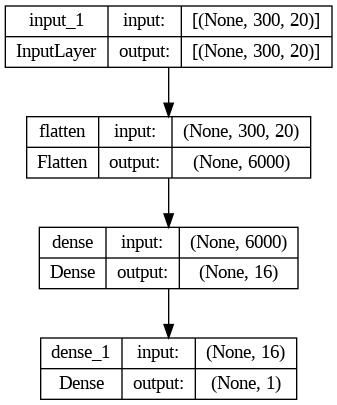

In [39]:
# Figure showing neural network
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_0, to_file='models/model_0.png', show_shapes=True, show_layer_names=True)

In [40]:
# Parameters for fitting and saving model training data
epochs = 200
model_0_filepath = 'models/model_dense.keras'
history_0_filepath = 'models/trainHistoryDict/model_0_dense_history.pkl'

In [41]:
# Fit the model to the training data
history_0 = model_0.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=True, 
                        epochs=epochs,
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_0_filepath,
                                            patience=5),
                        )

# Pickle the Traning Fit History
with open(history_0_filepath, 'wb') as file_pi:
    pickle.dump(history_0, file_pi)

Epoch 1/200
4830/4830 [==============================] - 24s 4ms/step - loss: 1.4036e-04 - binary_accuracy: 0.7628 - val_loss: 3.9724 - val_binary_accuracy: 0.7383
Epoch 2/200
4830/4830 [==============================] - 19s 4ms/step - loss: 1.6055e-04 - binary_accuracy: 0.8660 - val_loss: 3.4005 - val_binary_accuracy: 0.7764
Epoch 3/200
4830/4830 [==============================] - 18s 4ms/step - loss: 1.1272e-04 - binary_accuracy: 0.8261 - val_loss: 4.8667 - val_binary_accuracy: 0.6801
Epoch 4/200
4830/4830 [==============================] - 18s 4ms/step - loss: 1.0611e-04 - binary_accuracy: 0.8161 - val_loss: 4.5919 - val_binary_accuracy: 0.6987
Epoch 5/200
4830/4830 [==============================] - 18s 4ms/step - loss: 9.6956e-05 - binary_accuracy: 0.8541 - val_loss: 4.3682 - val_binary_accuracy: 0.7134
Epoch 6/200
4830/4830 [==============================] - 19s 4ms/step - loss: 9.8470e-05 - binary_accuracy: 0.8794 - val_loss: 3.0275 - val_binary_accuracy: 0.8015
Epoch 7/200
4830

1470/1470 [==============================] - 5s 3ms/step - loss: 3.0275 - binary_accuracy: 0.8015


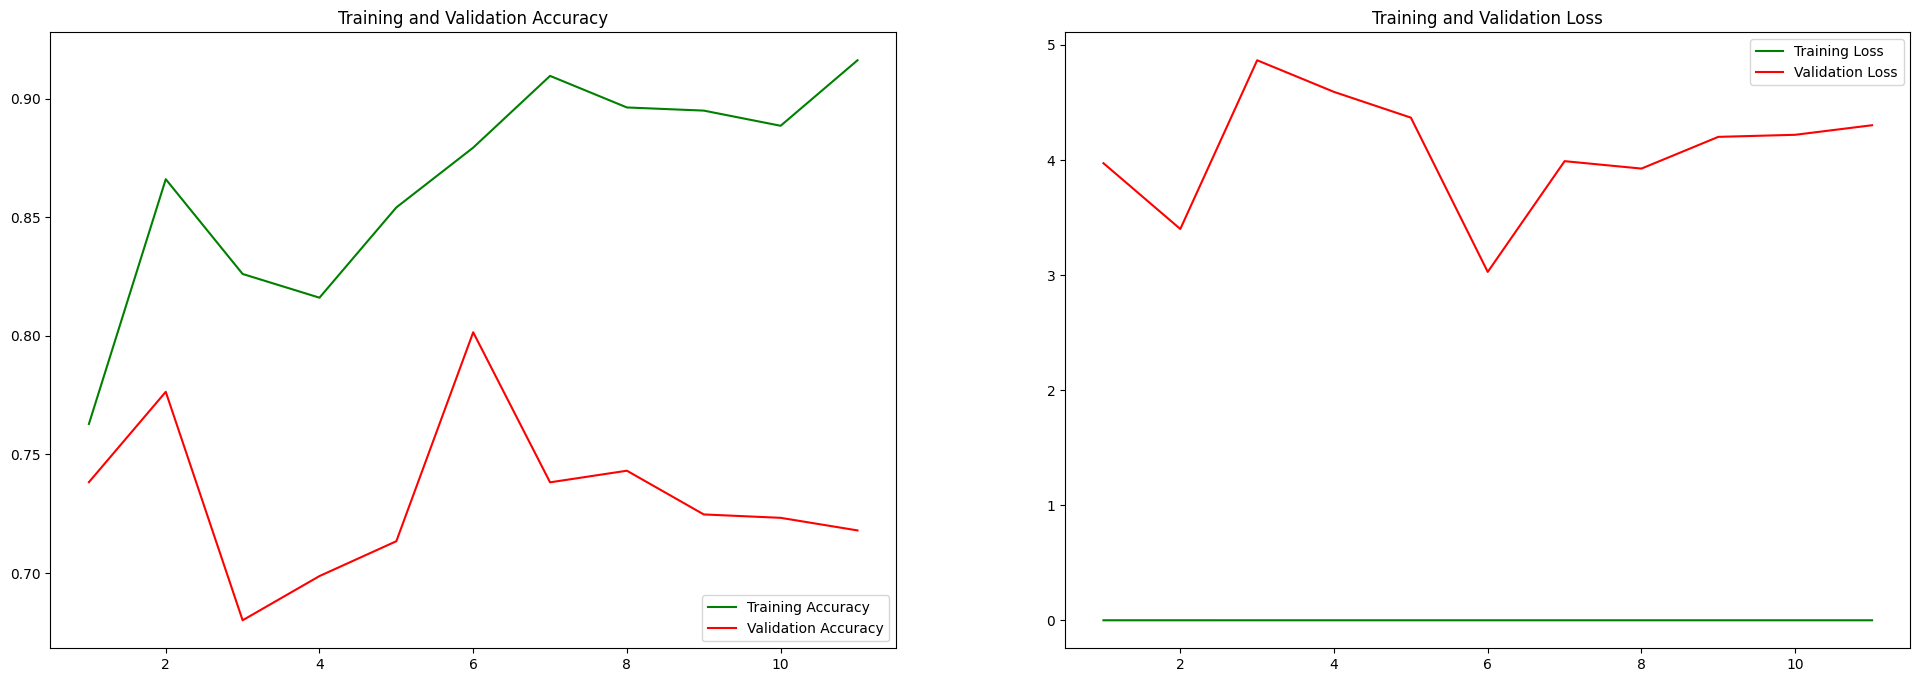

1530/1530 [==============================] - 5s 3ms/step - loss: 1.4530 - binary_accuracy: 0.9052
Validation Binary Accuracy is: 0.80
Testing Binary Accuracy is: 0.91


In [42]:
# Load and Evaluate Model
model_0, history_0 = evaluate_model(model_0_filepath, 
                         history_0_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_0_evaluation.pdf')

4830/4830 [==============================] - 7s 1ms/step


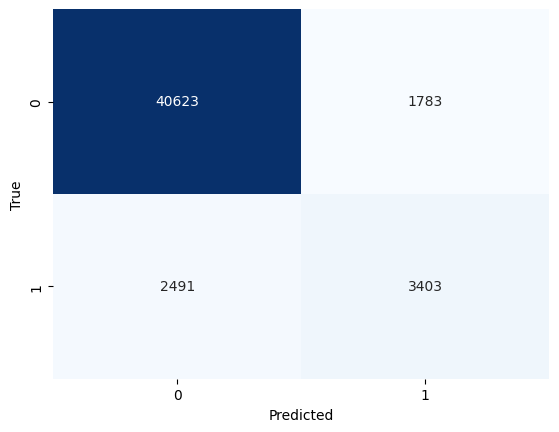

4830/4830 [==============================] - 7s 1ms/step
              precision    recall  f1-score       support
0              0.942223  0.957954  0.950023  42406.000000
1              0.656190  0.577367  0.614260   5894.000000
accuracy       0.911511  0.911511  0.911511      0.911511
macro avg      0.799206  0.767660  0.782142  48300.000000
weighted avg   0.907319  0.911511  0.909051  48300.000000
1470/1470 [==============================] - 2s 1ms/step


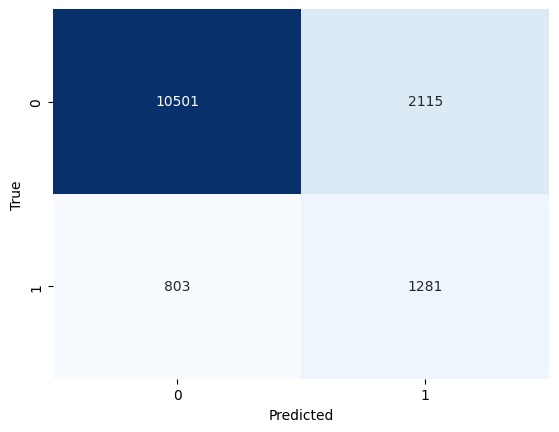

1470/1470 [==============================] - 2s 1ms/step
              precision    recall  f1-score       support
0              0.928963  0.832356  0.878010  12616.000000
1              0.377208  0.614683  0.467518   2084.000000
accuracy       0.801497  0.801497  0.801497      0.801497
macro avg      0.653086  0.723520  0.672764  14700.000000
weighted avg   0.850742  0.801497  0.819815  14700.000000
1530/1530 [==============================] - 2s 1ms/step


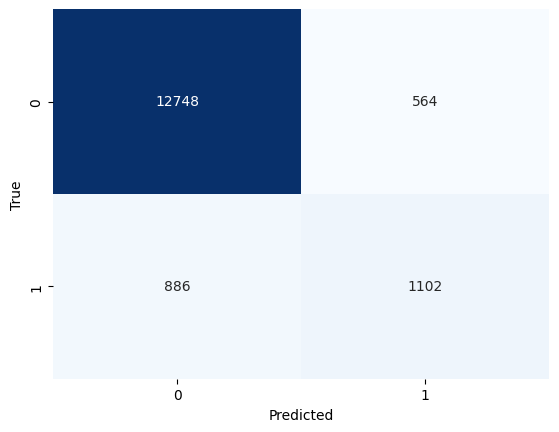

1530/1530 [==============================] - 2s 1ms/step
              precision    recall  f1-score       support
0              0.935015  0.957632  0.946189  13312.000000
1              0.661465  0.554326  0.603175   1988.000000
accuracy       0.905229  0.905229  0.905229      0.905229
macro avg      0.798240  0.755979  0.774682  15300.000000
weighted avg   0.899472  0.905229  0.901619  15300.000000


In [43]:
confusion_matrix_plot(model_0, train_gen, save_file='models/evaluate/model_0_train_confusion_matrix.pdf')
classification_report_output(model_0, train_gen, save_file=None)
confusion_matrix_plot(model_0, val_gen, save_file='models/evaluate/model_0_val_confusion_matrix.pdf')
classification_report_output(model_0, val_gen, save_file=None)
confusion_matrix_plot(model_0, test_gen, save_file='models/evaluate/model_0_test_confusion_matrix.pdf')
classification_report_output(model_0, test_gen, save_file=None)

In [44]:
# Hyperparameter Tuning
def nn_lstm_hyperparameter_tuning(build_model_fn, 
                                  lstm_units_list, 
                                  weight_penalty_list,
                                  learning_rates_list, 
                                  callback_filepath):
    '''
    Performs hyperparameter tuning for an LSTM-based neural network model. 
    It takes in a function that constructs the model with given 
    hyperparameters, as well as lists of `lstm_units`, `weight_penalty`, 
    and `learning_rates` to loop through. For each combination of 
    hyperparameters, the function trains the model on the training set and 
    evaluates its performance on the validation set using the F1-score. The 
    function returns the best model, hyperparameters, and history of the 
    training process. The `callbacks` function is also called to save the 
    best model based on the validation loss.
    '''
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Placeholder for the best model and its corresponding hyperparameters
    best_model = None
    best_lstm_units = None
    best_learning_rate = None
    best_penalty = None
    best_val_metric = -np.inf  # Set initial value to negative infinity

    # Loop through all combinations of LSTM units and learning rates
    for lstm_units in lstm_units_list:
        for learning_rate in learning_rates_list:
          for weight_penalty in weight_penalty_list:
            # Display the variables
            print(f'lstm_units: {lstm_units}, learning_rate: {learning_rate}, weight_penalty: {weight_penalty}')
            
            # Build model
            model = build_model_fn(lstm_units, learning_rate)

            # Set weight penalty
            class_weights_dict[1] = class_weights_dict[1] * weight_penalty         

            # Train the model on the training set
            history = model.fit(train_gen, 
                                shuffle=False,
                                validation_data=val_gen, 
                                epochs=epochs, 
                                class_weight=class_weights_dict,
                                callbacks=callbacks(callback_filepath,
                                                    patience=5))

            # Evaluate the model on the validation set
            y_val_true = np.concatenate([y for x, y in val_gen], axis=0)
            y_val_pred_probs = model.predict(val_gen)
            y_val_pred = (y_val_pred_probs > 0.5).astype(int)

            # Calculate the performance metric(s) of interest (e.g., F1-score)
            val_f1_score = f1_score(y_val_true, y_val_pred)

            # Update the best model and hyperparameters if the current model is better
            if val_f1_score > best_val_metric:
                best_history = history
                best_val_metric = val_f1_score
                best_model = model
                best_lstm_units = lstm_units
                best_learning_rate = learning_rate
                best_penalty = weight_penalty

    # Print the best LSTM units and learning rate
    print(f"Best LSTM units: {best_lstm_units}")
    print(f"Best learning rate: {best_learning_rate}")
    print(f"Best weight_penalty: {best_penalty}")

    return history, best_model, best_lstm_units, best_learning_rate, best_penalty


## Model 1

Model 1 includes a Long Short-Term Memory (LSTM) neural network architecture. LSTM models are a type of recurrent neural network that is particularly suited for time series data due to their ability to remember and use past information while processing new data points. LSTMs use special units, called memory cells, that can store information over a long period of time and selectively forget or update that information based on the current input. This allows the model to capture long-term dependencies in the data, which is often important in time series forecasting or classification tasks. LSTMs have been shown to outperform traditional machine learning models on a variety of time series problems.

Compared to Model 0, which is a simple densely connected neural network, the LSTM model is expected to have better performance in modeling time series data because it can capture the sequential dependencies within the data.

### Evaluation Metrics
Model 1 generally has higher precision for both non-stress and stress classes compared to Model 0. Model 1 shows improvements in recall for the stress class while maintaining similar recall for the non-stress class compared to Model 0. Model 1 exhibits higher F1-scores for the stress class in all datasets, indicating better balance between precision and recall compared to Model 0. Overall, Model 1 demonstrates improved performance in correctly identifying stress instances while maintaining similar performance for non-stress instances compared to Model 0. This suggests that Model 1 may be a more effective classifier for stress detection.

In [45]:
# Model 1
def build_lstm_model(lstm_units, learning_rate):
    from tensorflow import keras
    from tensorflow.keras.optimizers import Adam
    from keras.layers import Dense, LSTM

    inputs = keras.Input(shape=(seq_length, no_features))
    x = LSTM(units=lstm_units, 
          activation='tanh', 
          dropout=0.5)(inputs)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    return model

In [46]:
# Parameters for fitting and saving model training data
epochs = 200
model_1_filepath = 'models/model_1_lstm.keras'
history_1_filepath = 'models/trainHistoryDict/model_1_lstm_history.pkl'

In [47]:

lstm_units_list = [32]
learning_rates_list = [0.001]
class_weight_penalty= [1]
# Fit the model to the training data

history_1, model_1, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                                      build_lstm_model,
                                                                      lstm_units_list,
                                                                      class_weight_penalty,
                                                                      learning_rates_list,
                                                                      model_1_filepath)

# Pickle the Traning Fit History
with open(history_1_filepath, 'wb') as file_pi:
    pickle.dump(history_1, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm (LSTM)                 (None, 32)                6784      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4830/4830 [==============================] - 58s 11ms/step - loss: 1.6523e-05 - binary_accuracy: 0.8245 - val_loss: 0.7803 - val_binary_accuracy: 0.7088
Epoch 2/200
4830/4830 [==============================] - 54s 11ms/step - loss: 1.3934e-05 - binary_acc

1470/1470 [==============================] - 8s 5ms/step - loss: 0.6745 - binary_accuracy: 0.7758


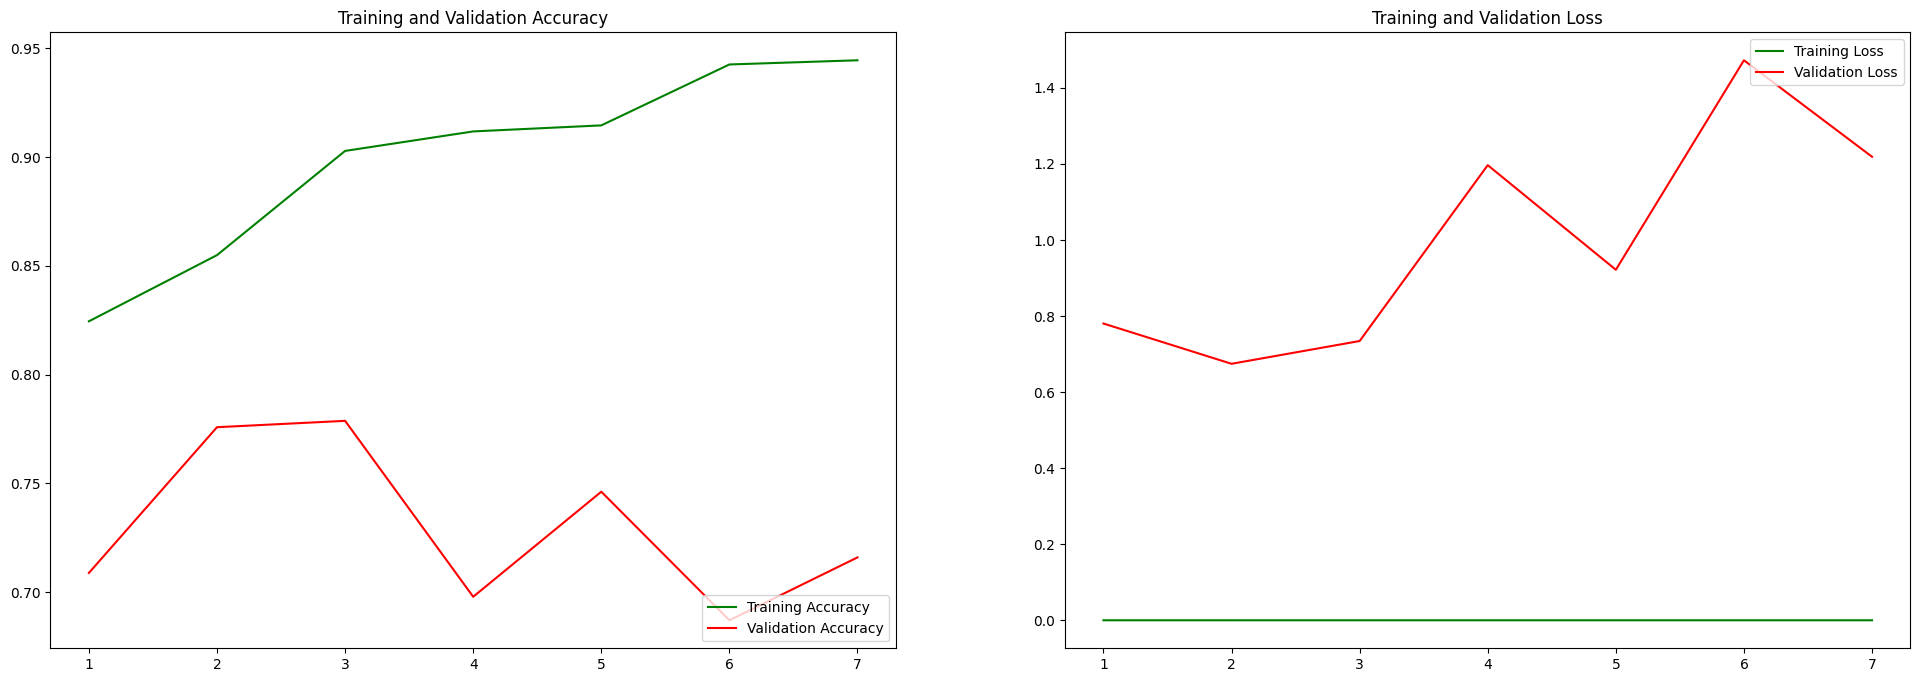

1530/1530 [==============================] - 8s 5ms/step - loss: 0.4905 - binary_accuracy: 0.8293
Validation Binary Accuracy is: 0.78
Testing Binary Accuracy is: 0.83


In [48]:
# Load and Evaluate Model
model_1, history_1 = evaluate_model(model_1_filepath, 
                         history_1_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_1_evaluation.pdf')

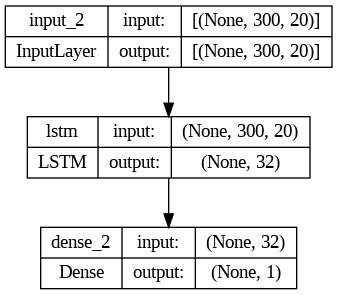

In [49]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_1, to_file='models/model_1_arch.png', show_shapes=True, show_layer_names=True)

4830/4830 [==============================] - 21s 4ms/step


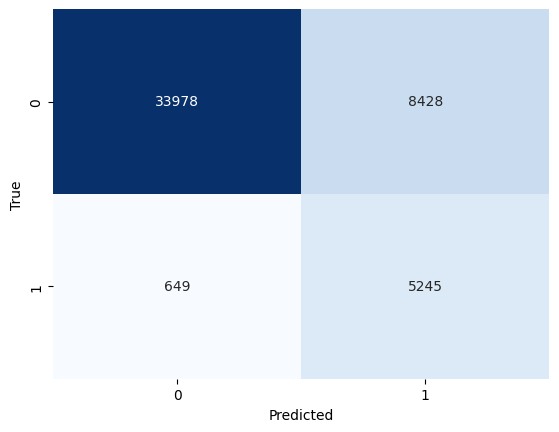

4830/4830 [==============================] - 21s 4ms/step
              precision    recall  f1-score      support
0              0.981257  0.801255  0.882167  42406.00000
1              0.383603  0.889888  0.536107   5894.00000
accuracy       0.812070  0.812070  0.812070      0.81207
macro avg      0.682430  0.845571  0.709137  48300.00000
weighted avg   0.908326  0.812070  0.839938  48300.00000
1470/1470 [==============================] - 7s 4ms/step


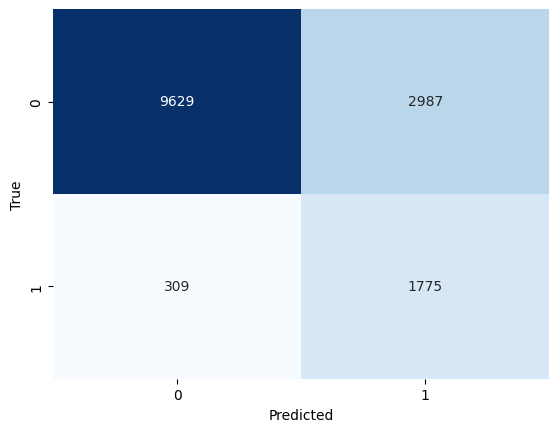

1470/1470 [==============================] - 6s 4ms/step
              precision    recall  f1-score       support
0              0.968907  0.763237  0.853862  12616.000000
1              0.372743  0.851727  0.518551   2084.000000
accuracy       0.775782  0.775782  0.775782      0.775782
macro avg      0.670825  0.807482  0.686206  14700.000000
weighted avg   0.884390  0.775782  0.806325  14700.000000
1530/1530 [==============================] - 7s 4ms/step


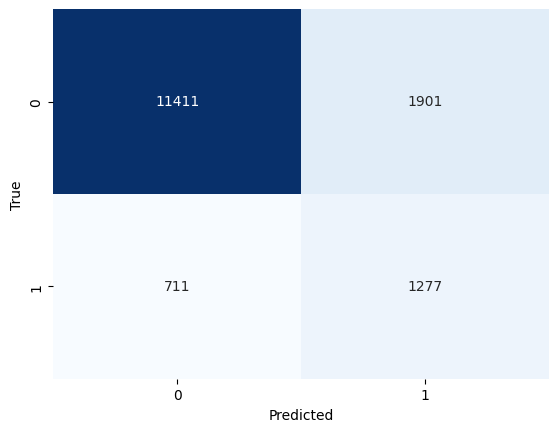

1530/1530 [==============================] - 7s 4ms/step
              precision    recall  f1-score       support
0              0.941346  0.857197  0.897303  13312.000000
1              0.401825  0.642354  0.494386   1988.000000
accuracy       0.829281  0.829281  0.829281      0.829281
macro avg      0.671586  0.749775  0.695845  15300.000000
weighted avg   0.871244  0.829281  0.844950  15300.000000


In [50]:
confusion_matrix_plot(model_1, train_gen, save_file='models/evaluate/model_1_train_confusion_matrix.pdf')
classification_report_output(model_1, train_gen, save_file=None)
confusion_matrix_plot(model_1, val_gen, save_file='models/evaluate/model_1_val_confusion_matrix.pdf')
classification_report_output(model_1, val_gen, save_file=None)
confusion_matrix_plot(model_1, test_gen, save_file='models/evaluate/model_1_test_confusion_matrix.pdf')
classification_report_output(model_1, test_gen, save_file=None)

## Model 2

This is an LSTM-based neural network architecture that is an improvement over model 1. The model consists of two LSTM layers with a dropout of 0.5 and an output layer. The first LSTM layer takes input of shape (300, 20) and returns a sequence of the same shape, which is then fed into the second LSTM layer. The second LSTM layer has half the number of units compared to the first LSTM layer. The output layer has a sigmoid activation function, which makes it suitable for binary classification problems. The dropout layers help to reduce overfitting, and the return_sequences parameter allows the model to process sequences of variable length.

### Evaluation Metrics
Based on the results obtained, model 2 has not shown any significant improvement compared to models 0 and 1. 

Model 2 architecture includes two LSTM layers with a lower number of LSTM units in the second layer compared to the first layer. The addition of the second LSTM layer is meant to provide more complex representations of the input data, which could help capture temporal patterns more effectively. Also, the use of the dropout layers can prevent overfitting and improve generalization.

However, the results suggest that model 2 did not perform better than the simpler model 0 and model 1. Model 2 generally has lower precision for both non-stress and stress classes compared to Models 0 and 1. Model 2 shows improvements in recall for the stress class compared to Models 0 and 1, but lower recall for the non-stress class.Model 2 generally has lower F1-scores for both non-stress and stress classes compared to Models 0 and 1. Overall, Model 2 demonstrates lower performance in correctly identifying stress instances and maintaining similar performance for non-stress instances compared to Models 0 and 1. This suggests that Model 2 may be less effective in stress detection compared to the previous models.

In [52]:
# Model 2
def build_lstm_2_model(lstm_units, learning_rate):
    import keras
    from keras.layers import LSTM, Dense
    from keras.models import Sequential
    from tensorflow.keras.optimizers import Adam

    # Build the model
    inputs = keras.Input(shape=(seq_length, no_features))

    # LSTM layer
    x = LSTM(lstm_units, 
            activation='tanh', 
            input_shape=(seq_length, no_features),
             return_sequences = True,
            dropout=0.5)(inputs) # Dropout
    # Second LSTM Layer
    x = LSTM(lstm_units//2,
            activation='tanh', 
            dropout=0.5)(x) # Dropout
    outputs = Dense(1, 'sigmoid')(x)
    model = keras.Model(inputs, outputs)

    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    model.summary()

    return model

In [53]:
model_2_filepath = 'models/model_2_multiLSTM.keras'
history_2_filepath = 'models/trainHistoryDict/model_2_dense_history.pkl'
lstm_units_list = [64]
#learning_rates_list = [best_learning_rate]
#class_weight_penalty= [best_penalty]

In [54]:
# Fit the model to the training data
history_2, model_2, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_model,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_2_filepath)
# Pickle the Traning Fit History
with open(history_2_filepath, 'wb') as file_pi:
    pickle.dump(history_2, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 300, 64)           21760     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4830/4830 [==============================] - 96s 19ms/step - loss: 2.1007e-05 - binary_accuracy: 0.7948 - val_loss: 0.5

1470/1470 [==============================] - 13s 8ms/step - loss: 0.4080 - binary_accuracy: 0.7603


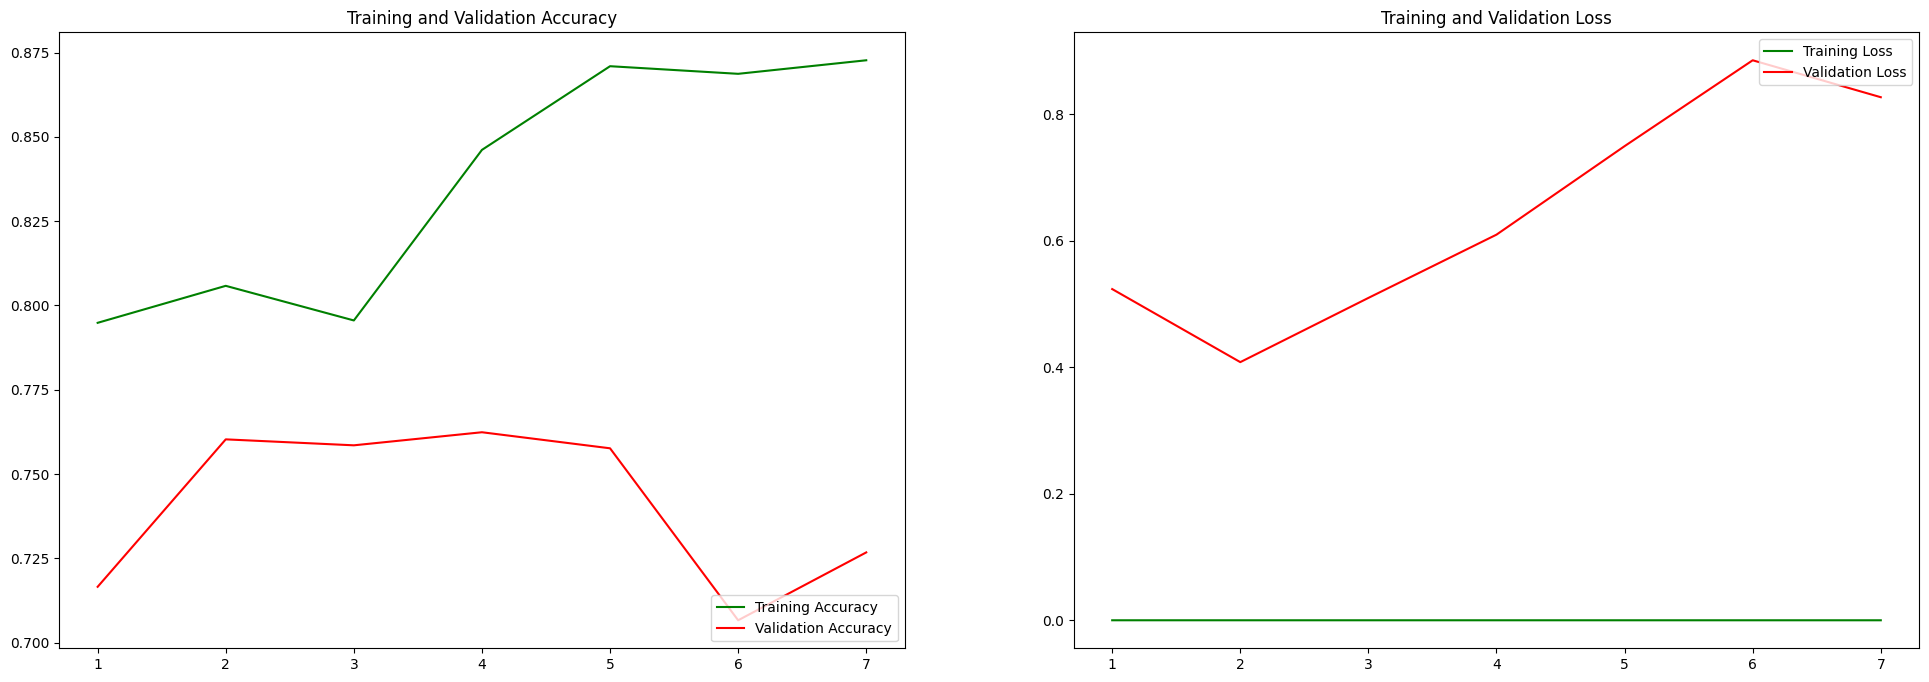

1530/1530 [==============================] - 13s 8ms/step - loss: 0.3931 - binary_accuracy: 0.7899
Validation Binary Accuracy is: 0.76
Testing Binary Accuracy is: 0.79


In [55]:
# Load and Evaluate Model
model_2, history_2 = evaluate_model(model_2_filepath, 
                         history_2_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_2_evaluation.pdf')

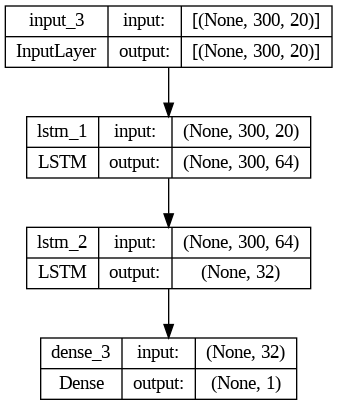

In [56]:
# Plot model visualization
from keras.utils import plot_model

plot_model(model_2, to_file='models/model_2_arch.png', show_shapes=True, show_layer_names=True)

4830/4830 [==============================] - 37s 7ms/step


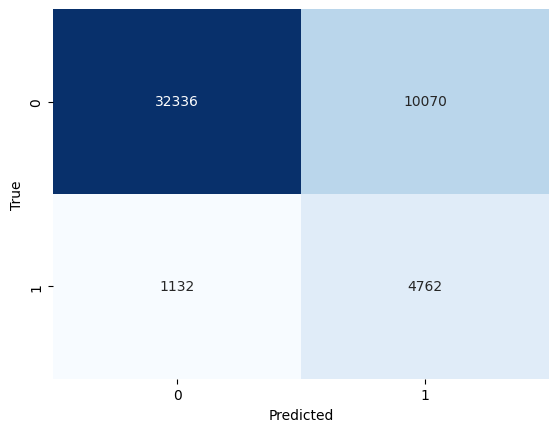

4830/4830 [==============================] - 36s 7ms/step
              precision    recall  f1-score       support
0              0.966177  0.762534  0.852360  42406.000000
1              0.321063  0.807940  0.459519   5894.000000
accuracy       0.768075  0.768075  0.768075      0.768075
macro avg      0.643620  0.785237  0.655940  48300.000000
weighted avg   0.887454  0.768075  0.804422  48300.000000
1470/1470 [==============================] - 11s 8ms/step


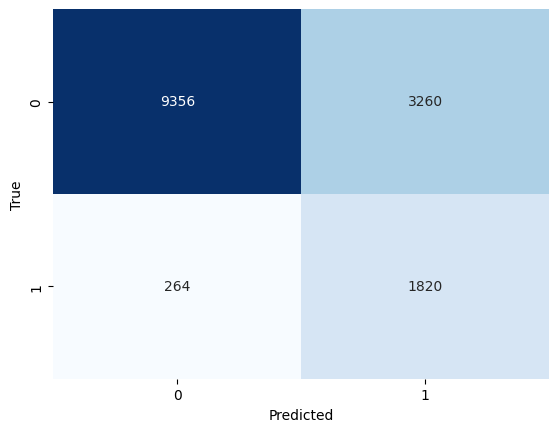

1470/1470 [==============================] - 11s 7ms/step
              precision    recall  f1-score       support
0              0.972557  0.741598  0.841518  12616.000000
1              0.358268  0.873321  0.508096   2084.000000
accuracy       0.760272  0.760272  0.760272      0.760272
macro avg      0.665412  0.807459  0.674807  14700.000000
weighted avg   0.885470  0.760272  0.794249  14700.000000
1530/1530 [==============================] - 11s 7ms/step


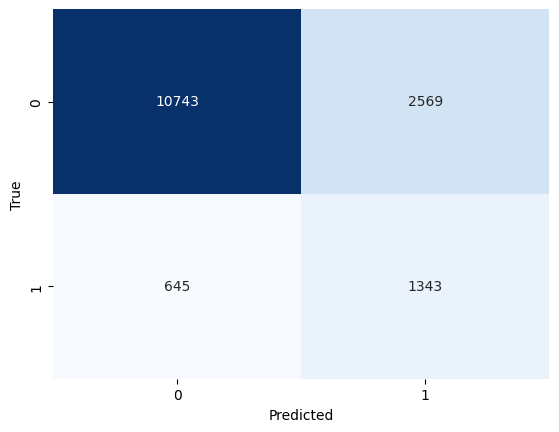

1530/1530 [==============================] - 12s 7ms/step
              precision    recall  f1-score       support
0              0.943361  0.807016  0.869879  13312.000000
1              0.343303  0.675553  0.455254   1988.000000
accuracy       0.789935  0.789935  0.789935      0.789935
macro avg      0.643332  0.741285  0.662566  15300.000000
weighted avg   0.865393  0.789935  0.816004  15300.000000


In [57]:
confusion_matrix_plot(model_2, train_gen, save_file='models/evaluate/model_2_train_confusion_matrix.pdf')
classification_report_output(model_2, train_gen, save_file=None)
confusion_matrix_plot(model_2, val_gen, save_file='models/evaluate/model_2_val_confusion_matrix.pdf')
classification_report_output(model_2, val_gen, save_file=None)
confusion_matrix_plot(model_2, test_gen, save_file='models/evaluate/model_2_test_confusion_matrix.pdf')
classification_report_output(model_2, test_gen, save_file=None)

## Model 3
The model architecture of Model 3 is similar to Model 2, with the addition of BatchNormalization layers after each LSTM layer. BatchNormalization is a technique that normalizes the inputs of each layer, making the training process more efficient and reducing the risk of overfitting.

By including BatchNormalization layers, Model 3 aims to further improve the performance of Model 2 by reducing the internal covariate shift and thus increasing the stability of the neural network. This can help the model to converge more quickly and achieve better results.

Given that time series data often involves temporal dependencies and correlations, LSTM models are commonly used for time series prediction tasks. By adding BatchNormalization layers to LSTM layers, Model 3 can better capture the temporal dynamics of the data, and thus improve its predictive power.

Compared to Model 1 and Model 2, Model 3 is expected to perform better, as it takes into account the temporal dependencies of the data and includes BatchNormalization layers to further improve the model's training stability and generalization ability.

### Evaluation Metrics
Model 3 has lower precision for both non-stress and stress classes compared to Models 0 and 1. However, it shows slightly higher precision for the stress class compared to Model 2. Model 3 has higher recall for both non-stress and stress classes compared to Models 0, 1, and 2. Model 3 generally has lower F1-scores for both non-stress and stress classes compared to Models 0 and 1. However, it shows slightly higher F1-scores for both classes compared to Model 2. Overall, Model 3 demonstrates lower performance compared to Models 0 and 1 in terms of precision and F1-score. However, it shows improved recall for both classes compared to all previous models. Model 3 may be more effective in identifying stress instances but at the cost of lower precision.



In [58]:
## Model 3
def build_lstm_2_norm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout
  from tensorflow.keras.optimizers import Adam
  from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

  # Build the model
  inputs = keras.Input(shape=(seq_length, no_features))

  # LSTM layer
  x = LSTM(lstm_units, 
          activation='tanh', 
          input_shape=(seq_length, no_features),
          return_sequences=True,
          dropout=0.5)(inputs) # Dropout
  # Second LSTM Layer
  x = BatchNormalization()(x)
  x = LSTM(lstm_units//2, 
          activation='tanh', 
          return_sequences=False,  # Set return_sequences=False
          dropout=0.5)(x) # Dropout
  x = BatchNormalization()(x)
  # Dense layer for binary prediction
  outputs = Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs, outputs)

  # Compile
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate=learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [59]:
model_3_filepath = 'models/model_3_multiLSTM.keras'
history_3_filepath = 'models/trainHistoryDict/model_3_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
#class_weight_penalty = [1, 2, 10, 100, 1000]

In [60]:
# Fit the model and tune hyperparameters
history_3, model_3, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_norm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_3_filepath)
# Pickle the Training Fit History
with open(history_3_filepath, 'wb') as file_pi:
    pickle.dump(history_3, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 300, 64)           21760     
                                                                 
 batch_normalization (BatchN  (None, 300, 64)          256       
 ormalization)                                                   
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 de

1470/1470 [==============================] - 13s 8ms/step - loss: 0.6691 - binary_accuracy: 0.7373


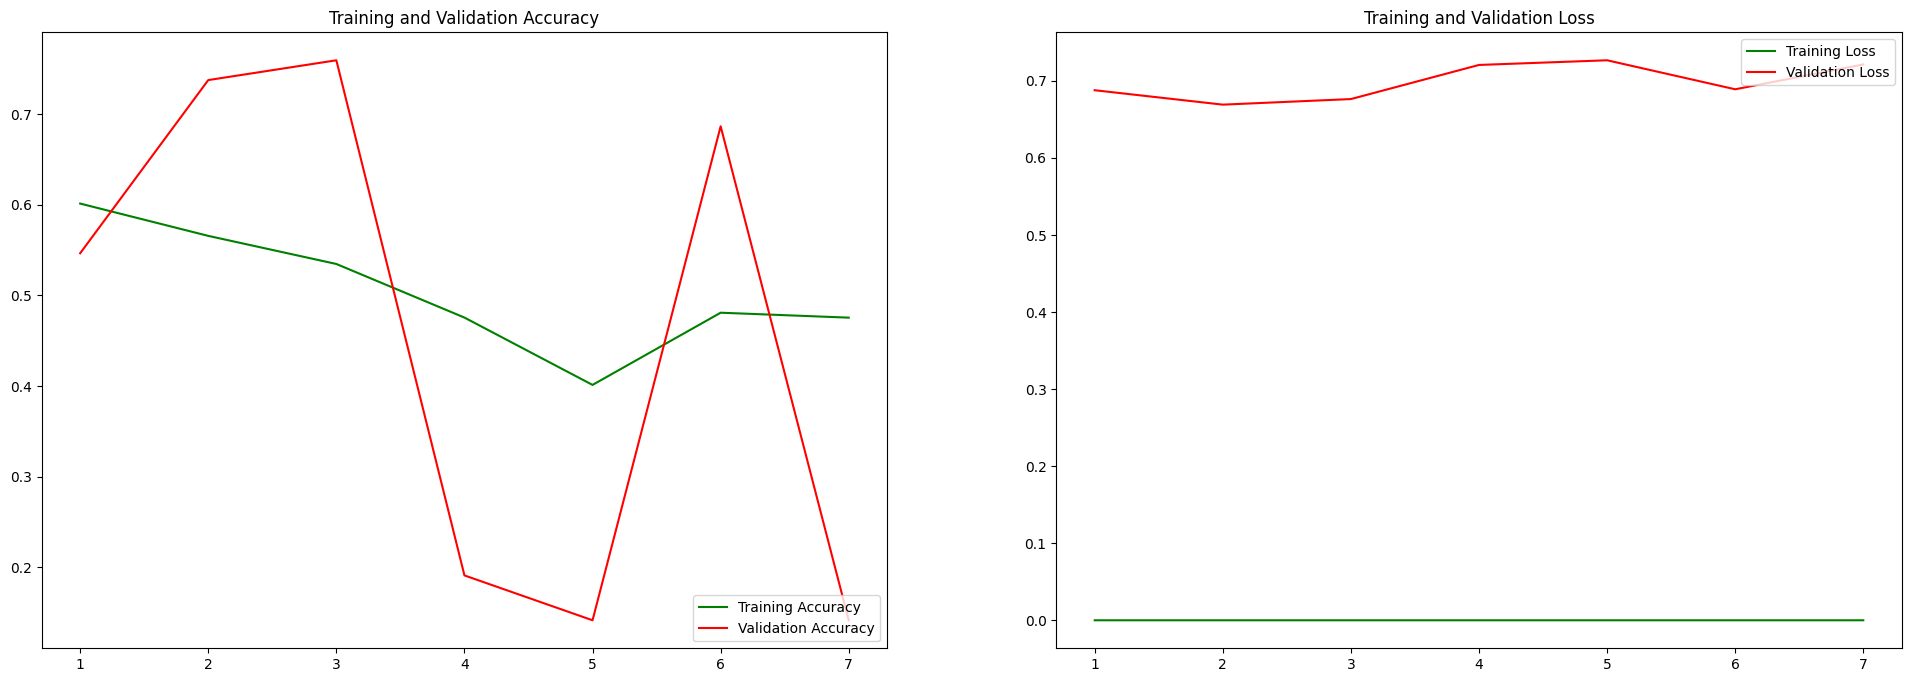

1530/1530 [==============================] - 13s 8ms/step - loss: 0.6824 - binary_accuracy: 0.6471
Validation Binary Accuracy is: 0.74
Testing Binary Accuracy is: 0.65


In [61]:
# Load and Evaluate Model
model_3, history_3 = evaluate_model(model_3_filepath, 
                         history_3_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_3_evaluation.pdf')

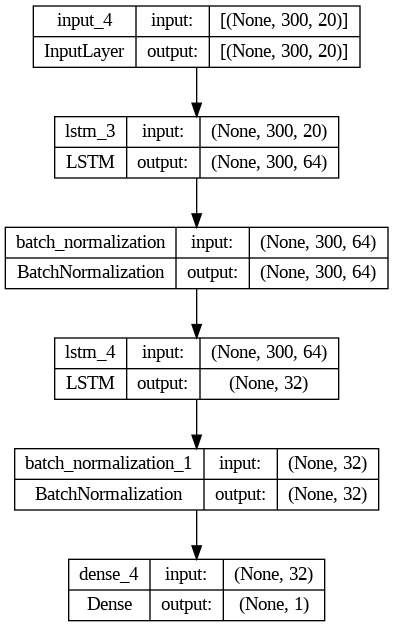

In [62]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_3, to_file='models/model_3_arch.png', show_shapes=True, show_layer_names=True)

4830/4830 [==============================] - 37s 8ms/step


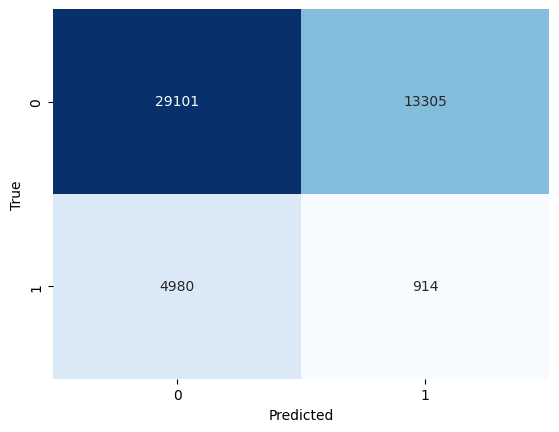

4830/4830 [==============================] - 36s 8ms/step
              precision    recall  f1-score       support
0              0.853878  0.686247  0.760940  42406.000000
1              0.064280  0.155073  0.090886   5894.000000
accuracy       0.621429  0.621429  0.621429      0.621429
macro avg      0.459079  0.420660  0.425913  48300.000000
weighted avg   0.757524  0.621429  0.679174  48300.000000
1470/1470 [==============================] - 11s 8ms/step


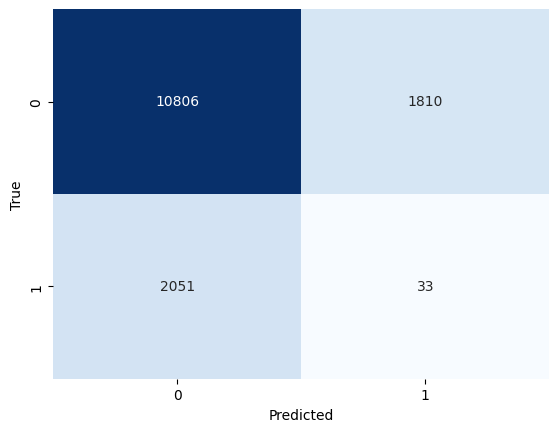

1470/1470 [==============================] - 11s 8ms/step
              precision    recall  f1-score       support
0              0.840476  0.856531  0.848428  12616.000000
1              0.017906  0.015835  0.016807   2084.000000
accuracy       0.737347  0.737347  0.737347      0.737347
macro avg      0.429191  0.436183  0.432617  14700.000000
weighted avg   0.723861  0.737347  0.730530  14700.000000
1530/1530 [==============================] - 12s 8ms/step


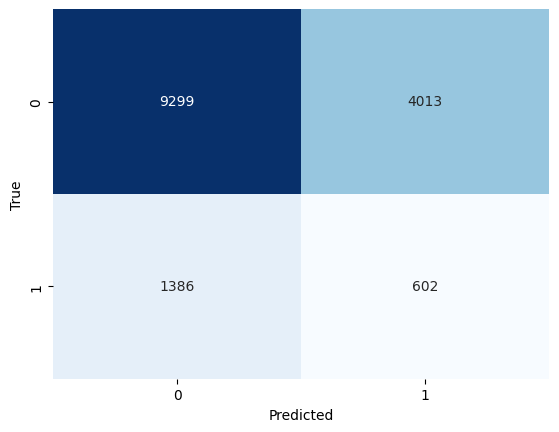

1530/1530 [==============================] - 12s 8ms/step
              precision    recall  f1-score       support
0              0.870285  0.698543  0.775014  13312.000000
1              0.130444  0.302817  0.182341   1988.000000
accuracy       0.647124  0.647124  0.647124      0.647124
macro avg      0.500365  0.500680  0.478677  15300.000000
weighted avg   0.774154  0.647124  0.698005  15300.000000


In [63]:
confusion_matrix_plot(model_3, train_gen, save_file='models/evaluate/model_3_train_confusion_matrix.pdf')
classification_report_output(model_3, train_gen, save_file=None)
confusion_matrix_plot(model_3, val_gen, save_file='models/evaluate/model_3_val_confusion_matrix.pdf')
classification_report_output(model_3, val_gen, save_file=None)
confusion_matrix_plot(model_3, test_gen, save_file='models/evaluate/model_3_test_confusion_matrix.pdf')
classification_report_output(model_3, test_gen, save_file=None)

## Model 4
Model 4 is a combination of a 1D convolutional layer and an LSTM layer. The 1D convolutional layer is used to extract features from the input data, which can be helpful for time series data like this. The output of the convolutional layer is then passed through a max pooling layer to reduce the dimensionality of the features. This process is repeated with another convolutional layer and max pooling layer. The output of the last max pooling layer is then fed into the LSTM layer, which can capture the temporal dependencies in the data.

The output of the LSTM layer is then flattened and passed through a dense layer with a ReLU activation function. A dropout layer is added to prevent overfitting, and the final output layer uses a sigmoid activation function for binary classification.

Compared to the previous models, model 4 adds a 1D convolutional layer to extract features from the data, which can be beneficial for time series data. Additionally, it uses a combination of both convolutional and LSTM layers, which can capture both local and temporal features in the data.

Overall, I expect model 4 to perform better than the previous models due to its ability to extract features from the data using the 1D convolutional layer and capture temporal dependencies using the LSTM layer.

### Evaluation
Model 4 performs poorly for both classes, as it predicts only the non-stress class (class 0) and ignores the stress class (class 1). It has lower precision, recall, and F1-score for the non-stress class compared to the other models. Model 4 is not able to effectively predict the stress instances.

In [64]:
# Model 4
def build_lstm_conv_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, no_features))

  # Add a 1D convolutional layer to extract features
  x = Conv1D(filters=lstm_units, kernel_size=9, activation='relu', padding='same')(inputs)
  x = MaxPooling1D(pool_size=2)(x)
  x = Conv1D(filters=lstm_units*2, kernel_size=3, activation='relu', padding='same')(x)
  x = MaxPooling1D(pool_size=2)(x)

  # LSTM layer
  x = LSTM(lstm_units, activation='tanh', return_sequences=True)(x)

  # Flatten the output
  x = Flatten()(x)

  # Dense layer
  x = Dense(lstm_units//2, activation='relu')(x)

  # Dropout layer
  x = Dropout(0.5)(x)

  # Add the output layer
  outputs = Dense(1, activation='sigmoid')(x)

  # Create the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model


In [65]:
# Parameters for fitting and saving model training data
epochs = 200
model_4_filepath = 'models/model_4_conv_lstm.keras'
history_4_filepath = 'models/trainHistoryDict/model_4_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.01]

In [66]:
# Fit the model and tune hyperparameters
history_4, model_4, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_conv_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_4_filepath)
# Pickle the Training Fit History
with open(history_4_filepath, 'wb') as file_pi:
    pickle.dump(history_4, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 conv1d (Conv1D)             (None, 300, 64)           11584     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 128)          0         
 1D)                                                             
                                                                 
 ls

1470/1470 [==============================] - 6s 4ms/step - loss: 0.6688 - binary_accuracy: 0.8582


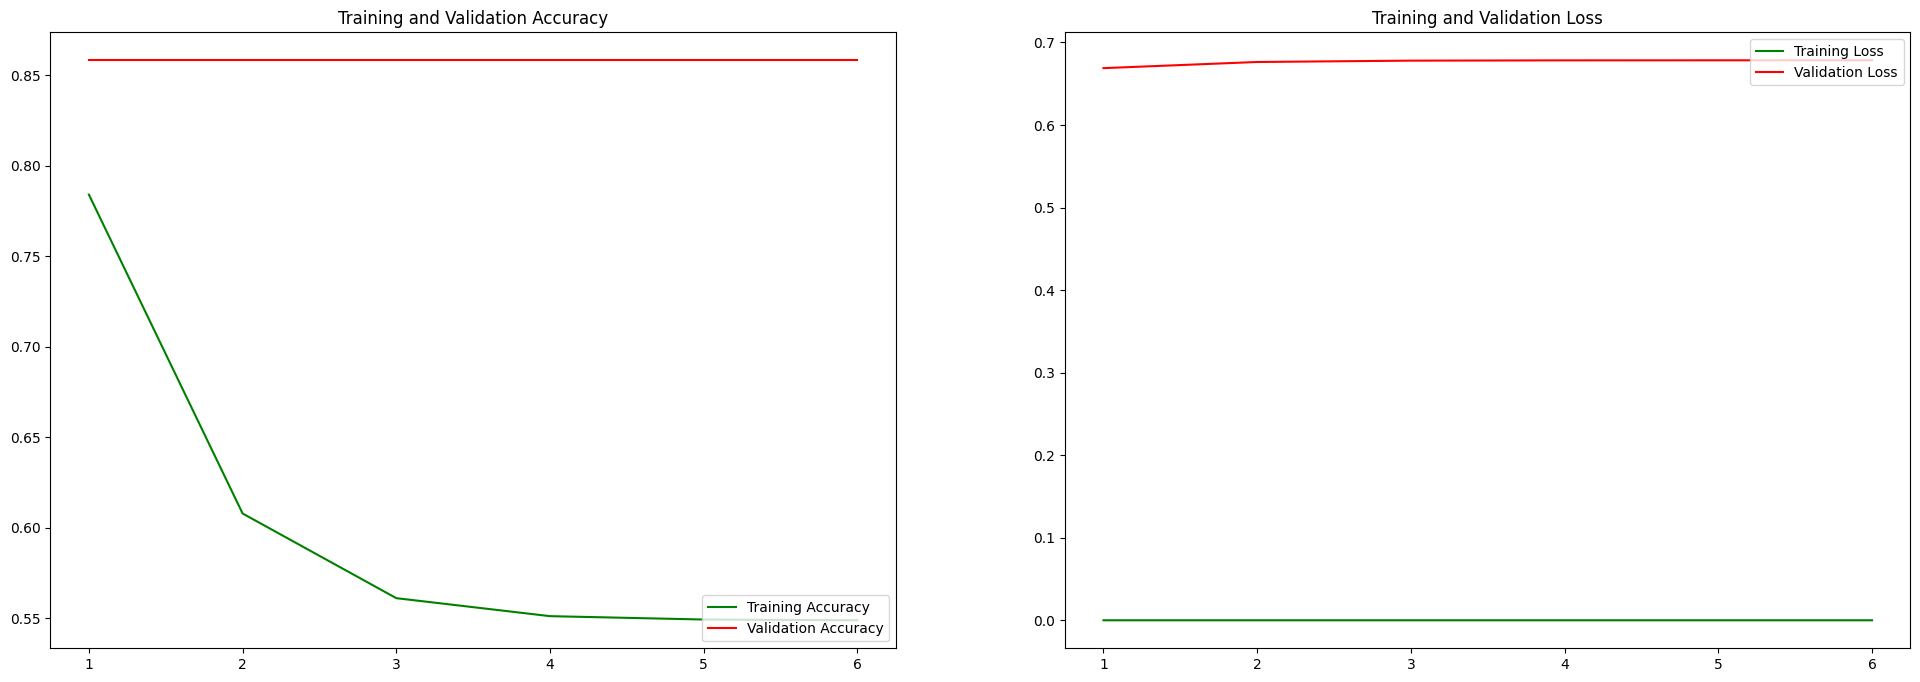

1530/1530 [==============================] - 6s 4ms/step - loss: 0.6680 - binary_accuracy: 0.8701
Validation Binary Accuracy is: 0.86
Testing Binary Accuracy is: 0.87


In [67]:
# Load and Evaluate Model
model_4, history_4 = evaluate_model(model_4_filepath, 
                         history_4_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_4_evaluation.pdf')

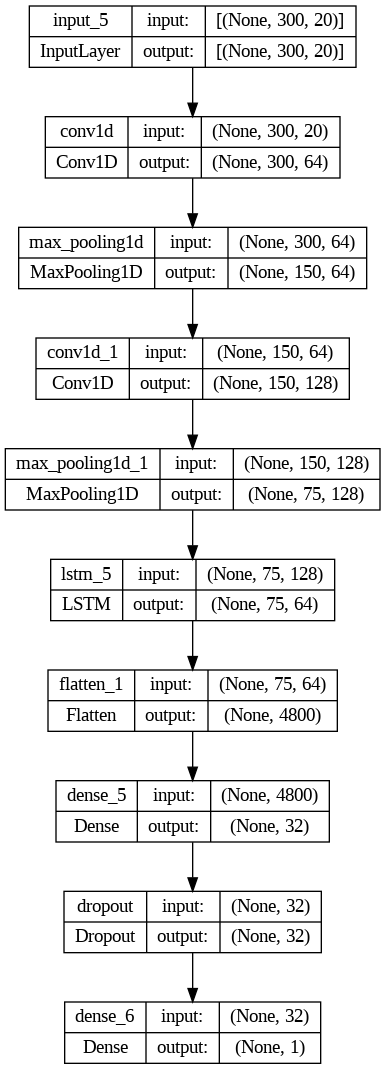

In [68]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_4, to_file='models/model_4_arch.png', show_shapes=True, show_layer_names=True)

4830/4830 [==============================] - 14s 3ms/step


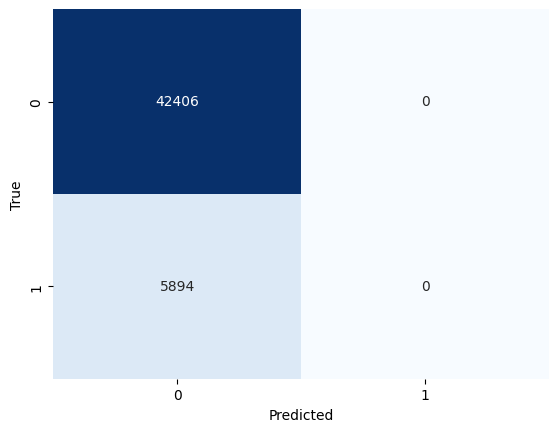

4830/4830 [==============================] - 14s 3ms/step
              precision    recall  f1-score       support
0              0.877971  1.000000  0.935021  42406.000000
1              0.000000  0.000000  0.000000   5894.000000
accuracy       0.877971  0.877971  0.877971      0.877971
macro avg      0.438986  0.500000  0.467510  48300.000000
weighted avg   0.770833  0.877971  0.820921  48300.000000
  39/1470 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1470/1470 [==============================] - 4s 3ms/step


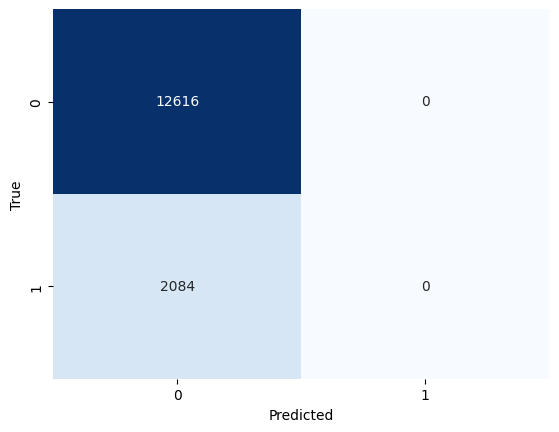

1470/1470 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.858231  1.000000  0.923708  12616.000000
1              0.000000  0.000000  0.000000   2084.000000
accuracy       0.858231  0.858231  0.858231      0.858231
macro avg      0.429116  0.500000  0.461854  14700.000000
weighted avg   0.736561  0.858231  0.792755  14700.000000
  38/1530 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1530/1530 [==============================] - 4s 3ms/step


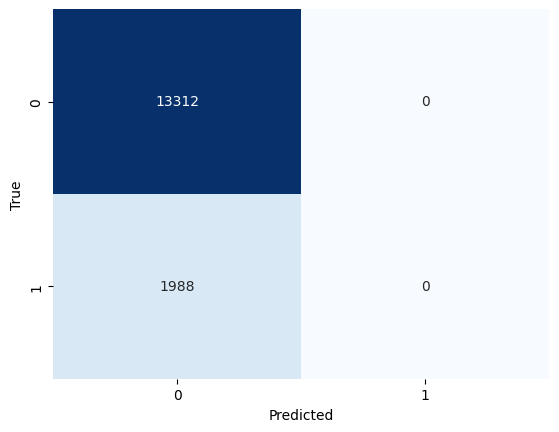

1530/1530 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.870065  1.000000  0.930519  13312.000000
1              0.000000  0.000000  0.000000   1988.000000
accuracy       0.870065  0.870065  0.870065      0.870065
macro avg      0.435033  0.500000  0.465259  15300.000000
weighted avg   0.757014  0.870065  0.809612  15300.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
confusion_matrix_plot(model_4, train_gen, save_file='models/evaluate/model_4_train_confusion_matrix.pdf')
classification_report_output(model_4, train_gen, save_file=None)
confusion_matrix_plot(model_4, val_gen, save_file='models/evaluate/model_4_val_confusion_matrix.pdf')
classification_report_output(model_4, val_gen, save_file=None)
confusion_matrix_plot(model_4, test_gen, save_file='models/evaluate/model_4_test_confusion_matrix.pdf')
classification_report_output(model_4, test_gen, save_file=None)

## Model 5
This model, which we will call model 5, is a combination of a Transformer block and an LSTM layer. The Transformer block is designed to learn the dependencies between the time steps of the input sequence and to generate a representation of the input sequence that is more informative and easier to process. The LSTM layer then takes the output of the Transformer block and learns to make predictions based on the temporal dependencies in the input sequence.

The input shape of the model is the same as the previous models, but the key difference is that it utilizes a Transformer block as the initial layer. The Transformer block has shown significant performance improvements over traditional recurrent neural networks like LSTMs, which were used in the previous models.

Overall, this model is expected to perform better than the previous models due to the use of the Transformer block, which should help to capture the temporal dependencies between the time steps of the input sequence and create a better representation of the data. Additionally, the use of an LSTM layer should help to capture the long-term dependencies in the data, making it more effective at making accurate predictions.

### Evaluation
Overall, Model 5 performs poorly for both classes, as it predicts only the non-stress class (class 0) and ignores the stress class (class 1). It has lower precision, recall, and F1-score for the non-stress class compared to the other models. Model 5 is not able to effectively predict the stress instances.

In [70]:
# Model 5: Transformer LSTM
def build_transform_lstm_1(lstm_units, learning_rate):
    from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, TransformerBlock
    from tensorflow.keras.models import Model

    # Define input shape
    input_shape = train_gen[0][0].shape[2]

    # Define input layer
    # Define the input shape
    inputs = Input(seq_length, shape=input_shape)

    # Add transformer block
    transformer_output = TransformerBlock(64, 2)(inputs)

    # Add LSTM layer
    plt.xcorr = LSTM(lstm_units)(transformer_output)

    # Add output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Define model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate), 
                  metrics=['binary_accuracy'])
    
    model.summary()

    return model


In [71]:
# Parameters for fitting and saving model training data
epochs = 200
model_5_filepath = 'models/model_5_conv_lstm.keras'
history_5_filepath = 'models/trainHistoryDict/model_5_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.01]

In [72]:
# Fit the model and tune hyperparameters
history_5, model_5, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_conv_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_5_filepath)
# Pickle the Training Fit History
with open(history_5_filepath, 'wb') as file_pi:
    pickle.dump(history_5, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 300, 64)           11584     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 150, 64)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 150, 128)          24704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 75, 128)          0         
 1D)                                                             
                                                                 
 ls

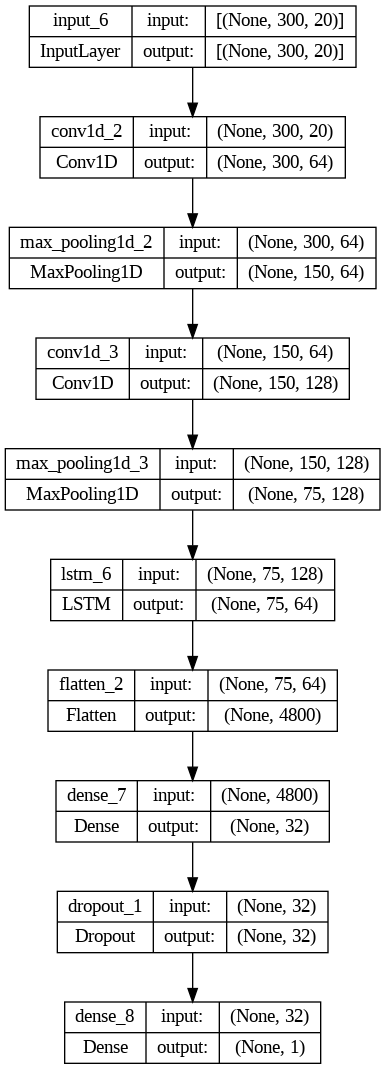

In [73]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_5, to_file='models/model_5_arch.png', show_shapes=True, show_layer_names=True)

4830/4830 [==============================] - 14s 3ms/step


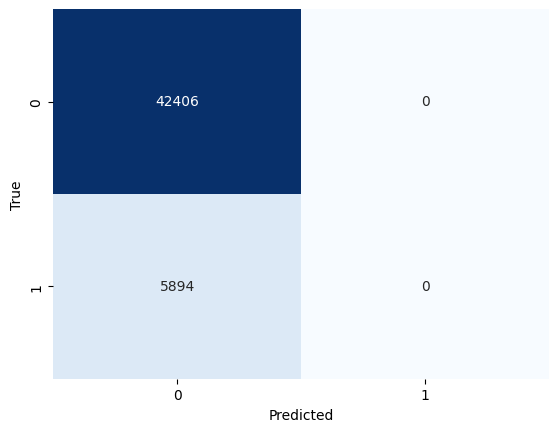

4830/4830 [==============================] - 14s 3ms/step
              precision    recall  f1-score       support
0              0.877971  1.000000  0.935021  42406.000000
1              0.000000  0.000000  0.000000   5894.000000
accuracy       0.877971  0.877971  0.877971      0.877971
macro avg      0.438986  0.500000  0.467510  48300.000000
weighted avg   0.770833  0.877971  0.820921  48300.000000
  37/1470 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1470/1470 [==============================] - 4s 3ms/step


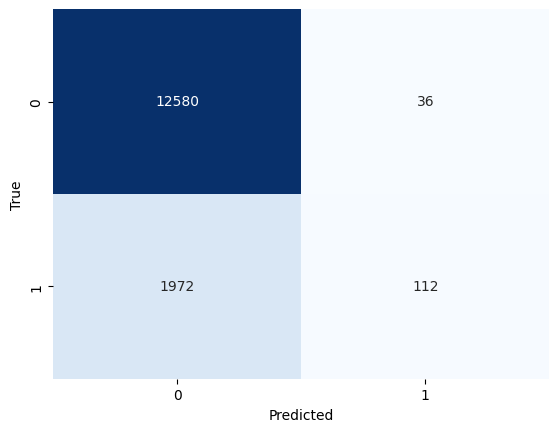

1470/1470 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.864486  0.997146  0.926090  12616.000000
1              0.756757  0.053743  0.100358   2084.000000
accuracy       0.863401  0.863401  0.863401      0.863401
macro avg      0.810621  0.525445  0.513224  14700.000000
weighted avg   0.849213  0.863401  0.809027  14700.000000
1530/1530 [==============================] - 4s 3ms/step


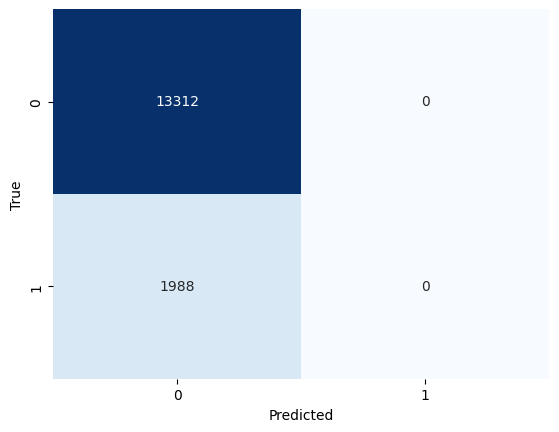

1530/1530 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.870065  1.000000  0.930519  13312.000000
1              0.000000  0.000000  0.000000   1988.000000
accuracy       0.870065  0.870065  0.870065      0.870065
macro avg      0.435033  0.500000  0.465259  15300.000000
weighted avg   0.757014  0.870065  0.809612  15300.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
confusion_matrix_plot(model_5, train_gen, save_file='models/evaluate/model_5_train_confusion_matrix.pdf')
classification_report_output(model_5, train_gen, save_file=None)
confusion_matrix_plot(model_5, val_gen, save_file='models/evaluate/model_5_val_confusion_matrix.pdf')
classification_report_output(model_5, val_gen, save_file=None)
confusion_matrix_plot(model_5, test_gen, save_file='models/evaluate/model_5_test_confusion_matrix.pdf')
classification_report_output(model_5, test_gen, save_file=None)

## Model 6
Model 6 is a bidirectional LSTM model which uses an LSTM layer that processes the input sequence in both directions, forward and backward. The model takes the input shape, and then applies two bidirectional LSTM layers, with 50% dropout rate. The final LSTM layer is then connected to a dense layer with a ReLU activation function. Finally, there is an output layer with a sigmoid activation function.

This model differs from the previous models in that it includes a bidirectional LSTM layer. The bidirectional layer allows the model to capture not only the past but also the future context of the input sequence. This is particularly useful when predicting events where future events may influence the final outcome. However, if the prediction solely depends on the past sequence, a bidirectional LSTM may not be the best model for the data.

### Evaluation
Model 6 is a bidirectional LSTM model that attempts to predict the output label based on a sequence of events. The model architecture consists of two bidirectional LSTMs with a Dense layer that follows. The model uses a dropout rate of 0.5 to reduce overfitting.

The classification report shows that Model 6 performs poorly for both classes. It has low precision, recall, and F1-score for the stress class, indicating that it struggles to correctly predict stress instances. It also has relatively low precision, recall, and F1-score for the non-stress class, indicating that it may have difficulty distinguishing between stress and non-stress instances.

In [75]:
# Model 6: Bidirectional LSTM
def build_bidirection_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Bidirectional
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, no_features))

  # Next model add a Dense layer here
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         return_sequences=True,
                         dropout=0.5))(inputs)
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         #return_sequences=True,
                         dropout=0.5))(x)
  x = Dense(units=batch_size//2, 
            activation='relu')(x)

  outputs = Dense(units=1, activation='sigmoid')(x)

  # Build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [76]:
# Parameters for fitting and saving model training data
epochs = 200
model_6_filepath = 'models/model_6_bidirectional.keras'
history_6_filepath = 'models/trainHistoryDict/model_6_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1] #[1, 2, 10, 100, 1000]

In [77]:
# Fit the model and tune hyperparameters
history_6, model_6, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_bidirection_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_6_filepath)
# Pickle the Training Fit History
with open(history_6_filepath, 'wb') as file_pi:
    pickle.dump(history_6, file_pi)

lstm_units: 64, learning_rate: 0.001, weight_penalty: 1
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         43520     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
 dense_10 (Dense)            (None, 1)                 6         
                                                                 
Tot

1470/1470 [==============================] - 23s 15ms/step - loss: 0.3664 - binary_accuracy: 0.8582


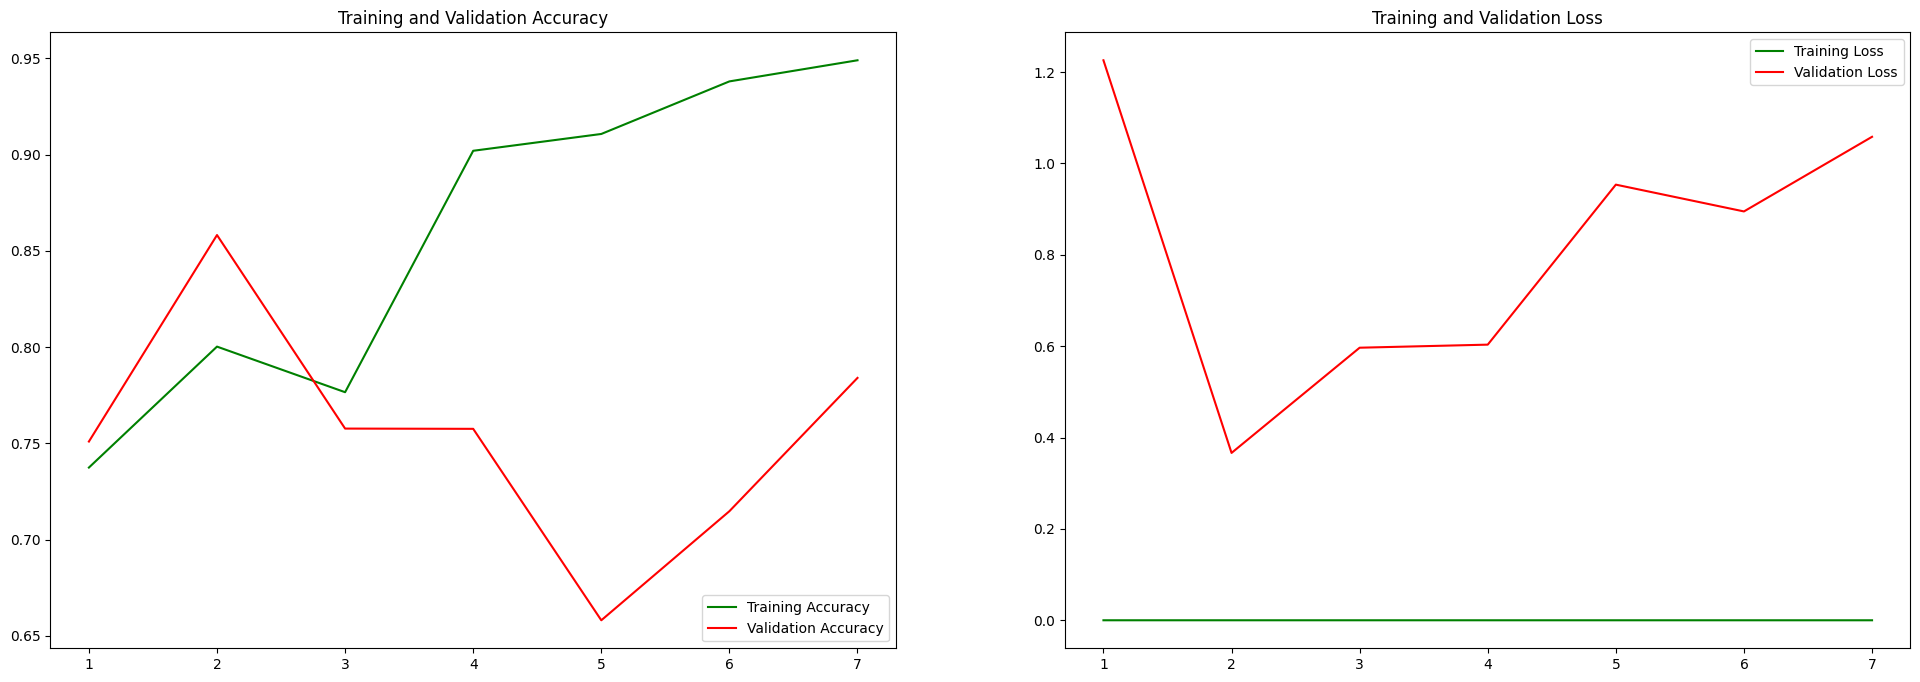

1530/1530 [==============================] - 22s 15ms/step - loss: 0.3886 - binary_accuracy: 0.8456
Validation Binary Accuracy is: 0.86
Testing Binary Accuracy is: 0.85


In [78]:
# Fit the model to the training data
# Load and Evaluate Model
model_6, history_6 = evaluate_model(model_6_filepath, 
                         history_6_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_6_evaluation.pdf')

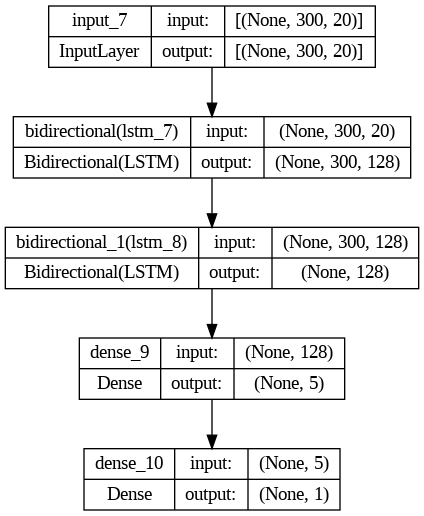

In [79]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_6, to_file='models/model_6_arch.png', show_shapes=True, show_layer_names=True)

4830/4830 [==============================] - 67s 14ms/step


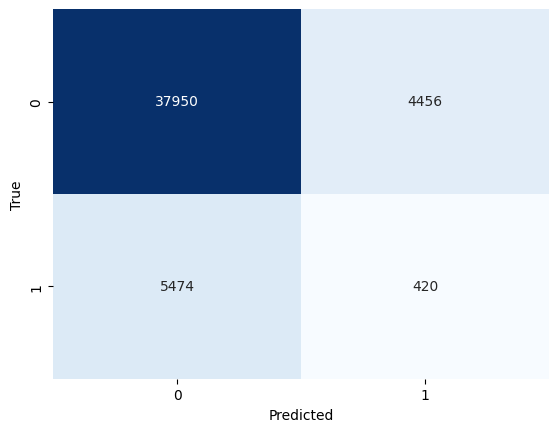

4830/4830 [==============================] - 66s 14ms/step
              precision    recall  f1-score      support
0              0.873941  0.894921  0.884306  42406.00000
1              0.086136  0.071259  0.077994   5894.00000
accuracy       0.794410  0.794410  0.794410      0.79441
macro avg      0.480038  0.483090  0.481150  48300.00000
weighted avg   0.777806  0.794410  0.785913  48300.00000
1470/1470 [==============================] - 20s 14ms/step


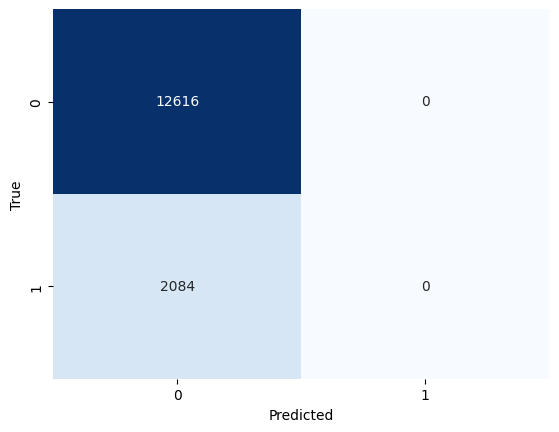

1470/1470 [==============================] - 20s 14ms/step
              precision    recall  f1-score       support
0              0.858231  1.000000  0.923708  12616.000000
1              0.000000  0.000000  0.000000   2084.000000
accuracy       0.858231  0.858231  0.858231      0.858231
macro avg      0.429116  0.500000  0.461854  14700.000000
weighted avg   0.736561  0.858231  0.792755  14700.000000
   5/1530 [..............................] - ETA: 21s 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1530/1530 [==============================] - 21s 14ms/step


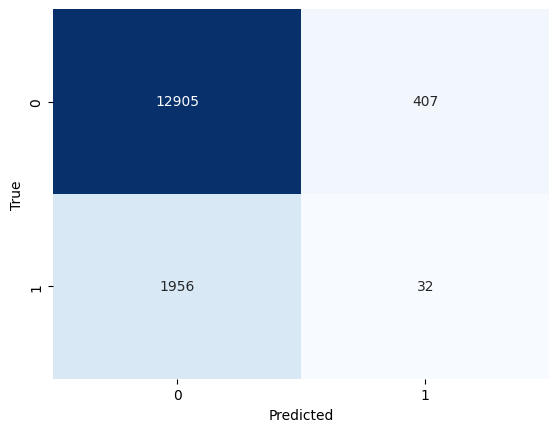

1530/1530 [==============================] - 21s 14ms/step
              precision    recall  f1-score       support
0              0.868380  0.969426  0.916125  13312.000000
1              0.072893  0.016097  0.026370   1988.000000
accuracy       0.845556  0.845556  0.845556      0.845556
macro avg      0.470637  0.492761  0.471248  15300.000000
weighted avg   0.765019  0.845556  0.800515  15300.000000


In [80]:
confusion_matrix_plot(model_6, train_gen, save_file='models/evaluate/model_6_train_confusion_matrix.pdf')
classification_report_output(model_6, train_gen, save_file=None)
confusion_matrix_plot(model_6, val_gen, save_file='models/evaluate/model_6_val_confusion_matrix.pdf')
classification_report_output(model_6, val_gen, save_file=None)
confusion_matrix_plot(model_6, test_gen, save_file='models/evaluate/model_6_test_confusion_matrix.pdf')
classification_report_output(model_6, test_gen, save_file=None)

## Model 7
Model 7 is a timeseries classification model that uses a transformer architecture. The transformer encoder is composed of a normalization and attention layer, followed by a feedforward neural network. The attention layer is applied to the inputs twice, and a residual connection is added to the output. The feedforward part consists of a convolutional layer and another residual connection. The global average pooling layer is added after the transformer blocks, followed by a fully connected network with a single output. 

Compared to the previous models, model 7 uses a transformer architecture instead of LSTM layers, which may be better suited for timeseries classification tasks. Additionally, it uses a multi-head attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. Finally, it uses global average pooling instead of LSTM or bidirectional LSTM layers, which reduces the number of parameters in the model and can help prevent overfitting.

### Evaluation

Model 7 performs poorly for both classes. It has low precision, recall, and F1-score for the non-stress class, indicating that it fails to predict non-stress instances. It has high recall for the stress class, but very low precision and F1-score, indicating that it incorrectly predicts many instances as stress.

In [81]:
'''
Model_7: Timeseries classification with a transformer model
'''
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(seq_length, no_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Build model
model_7 = build_transformer_model(
                seq_length,
                n_classes=1,
                head_size=256,
                num_heads=4, # Number of Transformer repeats
                ff_dim=4,
                num_transformer_blocks=4,
                mlp_units=[128],
                mlp_dropout=0.4,
                dropout=0.5,
)
best_learning_rate = 0.001

# Compile Model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"],
)
model_7.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 300, 20)]    0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 300, 20)     40          ['input_8[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 300, 20)     85012       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                            

In [82]:
# Parameters for fitting and saving model training data
epochs = 200
model_7_filepath = 'models/model_7_transformer.keras'
history_7_filepath = 'models/trainHistoryDict/model_7_history.pkl'

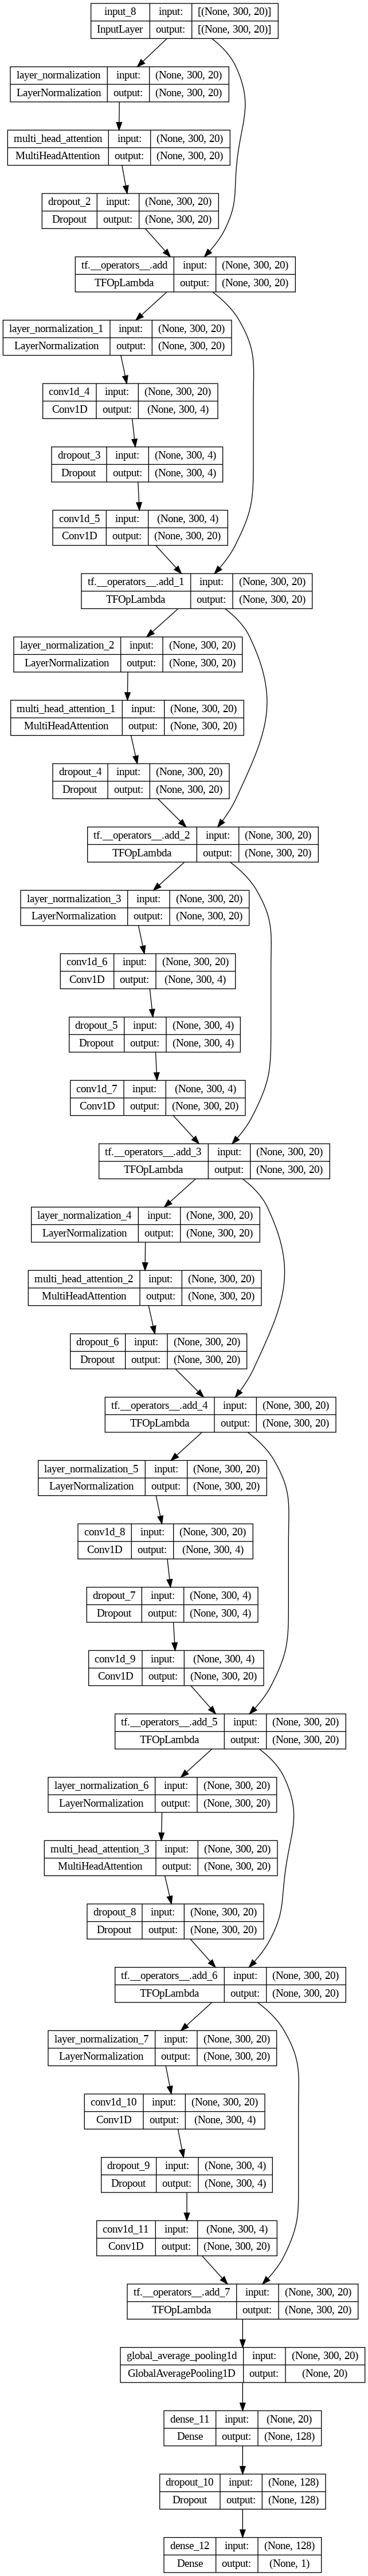

In [83]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_7, to_file='models/model_7_arch.png', show_shapes=True, show_layer_names=True)

In [84]:
# Fit the model to the training data
history_7 = model_7.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_7_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_7_filepath, 'wb') as file_pi:
    pickle.dump(history_7, file_pi)

Epoch 1/200
4830/4830 [==============================] - 228s 45ms/step - loss: 1.3247e-05 - binary_accuracy: 0.1220 - val_loss: 13.3055 - val_binary_accuracy: 0.1418
Epoch 2/200
4830/4830 [==============================] - 214s 44ms/step - loss: 1.7831e-05 - binary_accuracy: 0.1220 - val_loss: 1.8479 - val_binary_accuracy: 0.1418
Epoch 3/200
4830/4830 [==============================] - 213s 44ms/step - loss: 1.1768e-05 - binary_accuracy: 0.1220 - val_loss: 2.6880 - val_binary_accuracy: 0.1418
Epoch 4/200
4830/4830 [==============================] - 214s 44ms/step - loss: 1.7250e-05 - binary_accuracy: 0.1220 - val_loss: 1.6261 - val_binary_accuracy: 0.1418
Epoch 5/200
4830/4830 [==============================] - 213s 44ms/step - loss: 2.5114e-05 - binary_accuracy: 0.1220 - val_loss: 0.5020 - val_binary_accuracy: 0.1418
Epoch 6/200
4830/4830 [==============================] - 212s 44ms/step - loss: 2.3799e-05 - binary_accuracy: 0.1220 - val_loss: 0.8463 - val_binary_accuracy: 0.1418
Epo

1470/1470 [==============================] - 22s 14ms/step - loss: 0.5020 - binary_accuracy: 0.1418


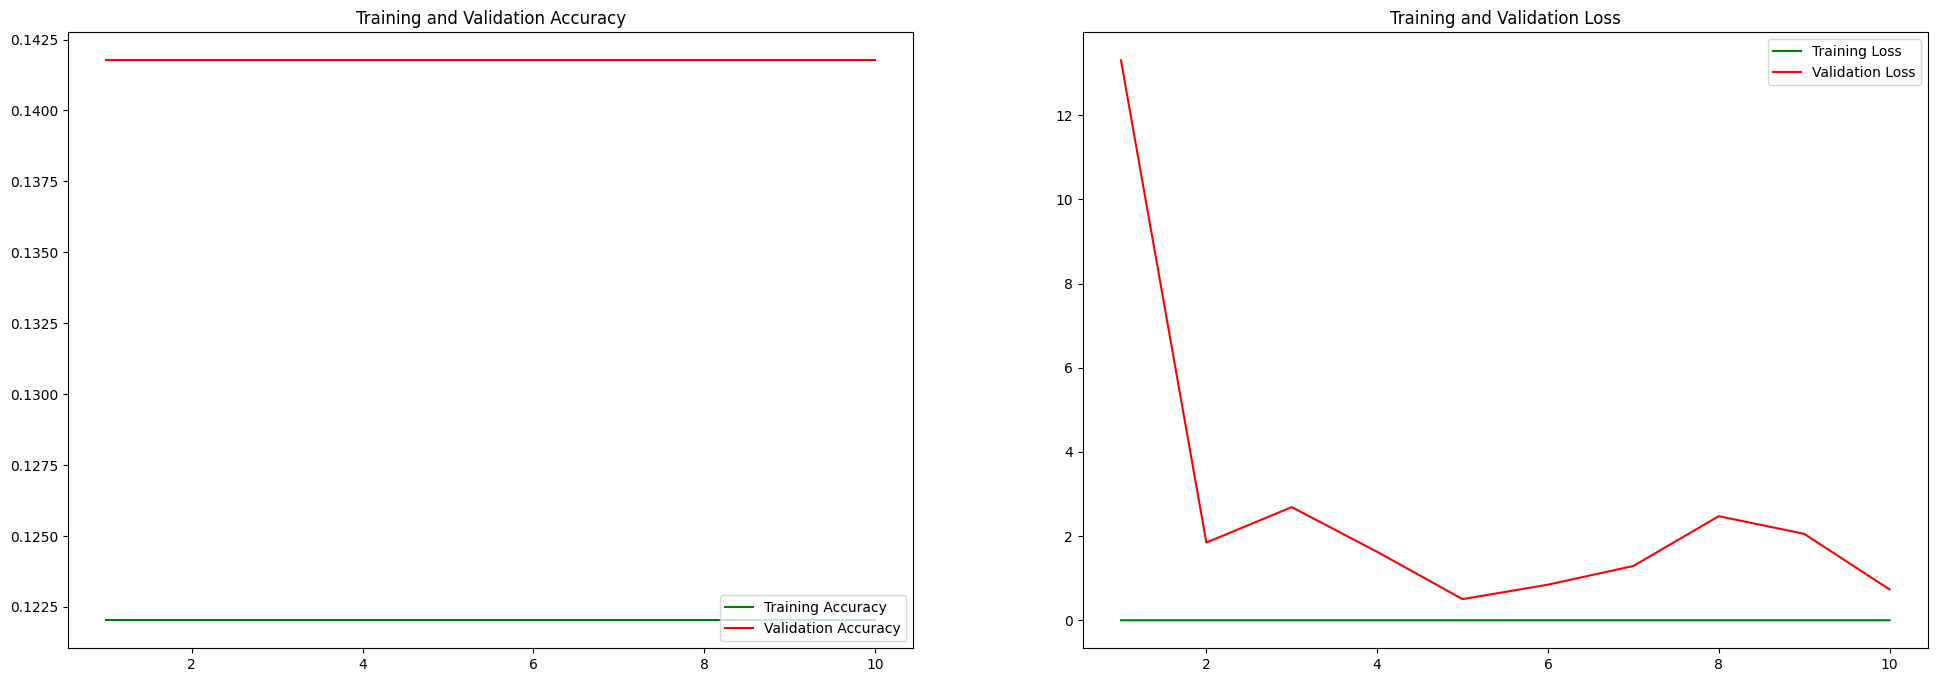

1530/1530 [==============================] - 22s 14ms/step - loss: 1.0684 - binary_accuracy: 0.1299
Validation Binary Accuracy is: 0.14
Testing Binary Accuracy is: 0.13


In [85]:
# Load and Evaluate Model
model_7, history_7 = evaluate_model(model_7_filepath, 
                         history_7_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_7_evaluation.pdf')

4830/4830 [==============================] - 64s 13ms/step


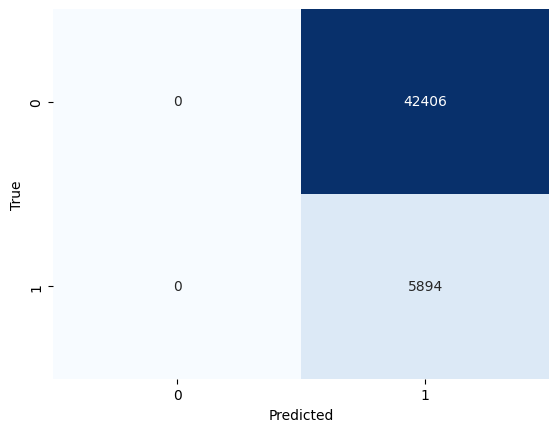

4830/4830 [==============================] - 64s 13ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  42406.000000
1              0.122029  1.000000  0.217515   5894.000000
accuracy       0.122029  0.122029  0.122029      0.122029
macro avg      0.061014  0.500000  0.108757  48300.000000
weighted avg   0.014891  0.122029  0.026543  48300.000000
   4/1470 [..............................] - ETA: 26s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1470/1470 [==============================] - 19s 13ms/step


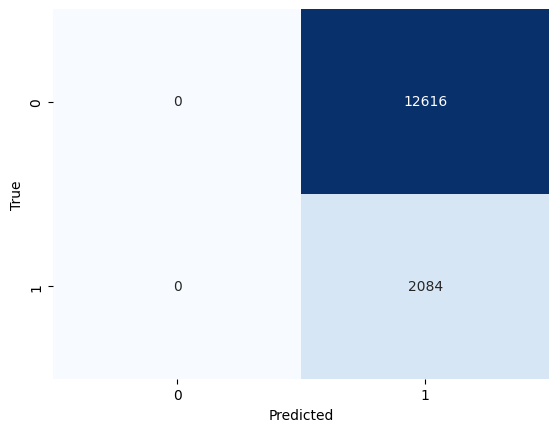

1470/1470 [==============================] - 19s 13ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  12616.000000
1              0.141769  1.000000  0.248332   2084.000000
accuracy       0.141769  0.141769  0.141769      0.141769
macro avg      0.070884  0.500000  0.124166  14700.000000
weighted avg   0.020098  0.141769  0.035206  14700.000000
  10/1530 [..............................] - ETA: 18s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1530/1530 [==============================] - 20s 13ms/step


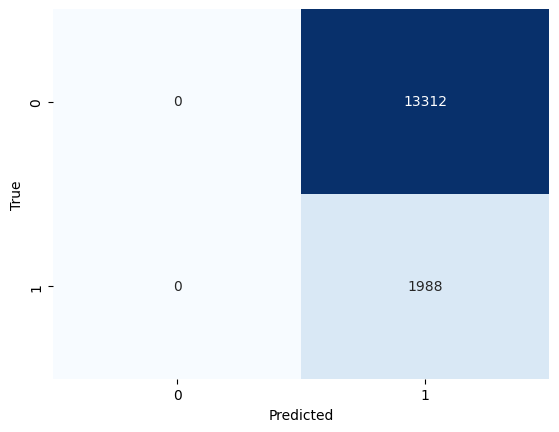

1530/1530 [==============================] - 20s 13ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  13312.000000
1              0.129935  1.000000  0.229986   1988.000000
accuracy       0.129935  0.129935  0.129935      0.129935
macro avg      0.064967  0.500000  0.114993  15300.000000
weighted avg   0.016883  0.129935  0.029883  15300.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
confusion_matrix_plot(model_7, train_gen, save_file='models/evaluate/model_7_train_confusion_matrix.pdf')
classification_report_output(model_7, train_gen, save_file=None)
confusion_matrix_plot(model_7, val_gen, save_file='models/evaluate/model_7_val_confusion_matrix.pdf')
classification_report_output(model_7, val_gen, save_file=None)
confusion_matrix_plot(model_7, test_gen, save_file='models/evaluate/model_7_test_confusion_matrix.pdf')
classification_report_output(model_7, test_gen, save_file=None)

## Model 8
This architecture combines the strengths of LSTM and Transformer layers. The LSTM layer captures sequential patterns, while the Transformer blocks enable the model to learn both local and global dependencies in the timeseries data. This combination can potentially improve the model's ability to detect stress patterns in the input timeseries.


### Evaluation
Model 8 performs very poorly for the stress classe. It fails to predict any instances correctly, as it only predicts the normal state (class 0).

In [87]:
# Model 8
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_lstm_model(input_shape, n_classes, head_size, num_heads, ff_dim, num_transformer_blocks, lstm_units, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # LSTM layer
    lstm_out = layers.LSTM(lstm_units, return_sequences=True)(x)

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(lstm_out, head_size, num_heads, ff_dim, dropout)

    # Flatten and MLP layers
    x = layers.Flatten()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Define model hyperparameters
seq_length = 300
n_classes = 1
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
lstm_units = 64
mlp_units = [128]
mlp_dropout = 0.4
dropout = 0.5

# Build the model
model_8 = build_transformer_lstm_model(
    input_shape=(seq_length, train_gen[0][0].shape[2]),
    n_classes=n_classes,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    lstm_units=lstm_units,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

# Compile the model
best_learning_rate = 0.001
model_8.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"]
)

# Print the model summary
model_8.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300, 20)]    0           []                               
                                                                                                  
 lstm_9 (LSTM)                  (None, 300, 64)      21760       ['input_9[0][0]']                
                                                                                                  
 layer_normalization_14 (LayerN  (None, 300, 64)     128         ['lstm_9[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 300, 64)     265280      ['layer_normalization_14[0]

In [88]:
# Parameters for fitting and saving model training data
epochs = 200
model_8_filepath = 'models/model_8_transformer.keras'
history_8_filepath = 'models/trainHistoryDict/model_8_history.pkl'

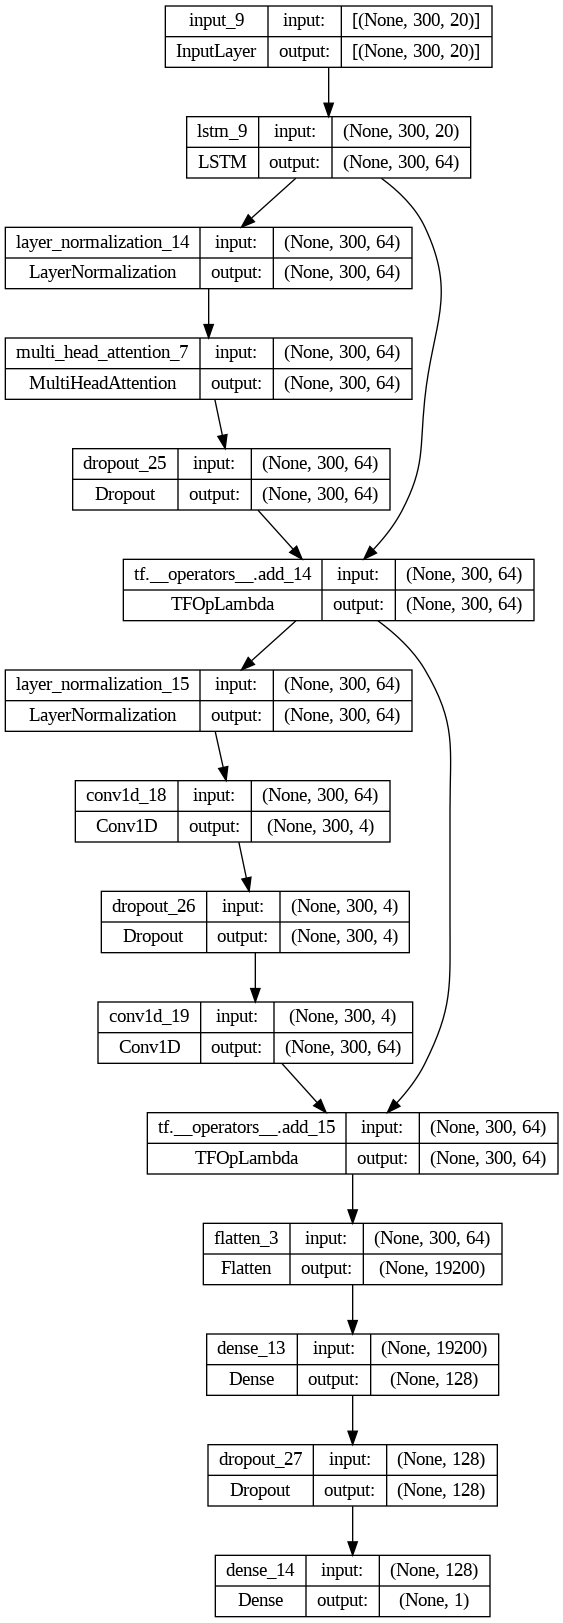

In [89]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_8, to_file='models/model_8_arch.png', show_shapes=True, show_layer_names=True)

In [90]:
# Fit the model to the training data
history_8 = model_8.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_8_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_8_filepath, 'wb') as file_pi:
    pickle.dump(history_8, file_pi)

Epoch 1/200
4830/4830 [==============================] - 108s 21ms/step - loss: 2.9881e-04 - binary_accuracy: 0.8165 - val_loss: 8.2926 - val_binary_accuracy: 0.8573
Epoch 2/200
4830/4830 [==============================] - 102s 21ms/step - loss: 9.1961e-05 - binary_accuracy: 0.6484 - val_loss: 0.6763 - val_binary_accuracy: 0.8582
Epoch 3/200
4830/4830 [==============================] - 101s 21ms/step - loss: 2.8721e-05 - binary_accuracy: 0.5578 - val_loss: 0.6782 - val_binary_accuracy: 0.8582
Epoch 4/200
4830/4830 [==============================] - 101s 21ms/step - loss: 8.9902e-05 - binary_accuracy: 0.5129 - val_loss: 0.7334 - val_binary_accuracy: 0.1418
Epoch 5/200
4830/4830 [==============================] - 101s 21ms/step - loss: 1.2570e-04 - binary_accuracy: 0.2693 - val_loss: 0.7283 - val_binary_accuracy: 0.1418
Epoch 6/200
4830/4830 [==============================] - 102s 21ms/step - loss: 2.8716e-05 - binary_accuracy: 0.3199 - val_loss: 0.6880 - val_binary_accuracy: 0.8582
Epoc

1470/1470 [==============================] - 12s 8ms/step - loss: 0.6763 - binary_accuracy: 0.8582


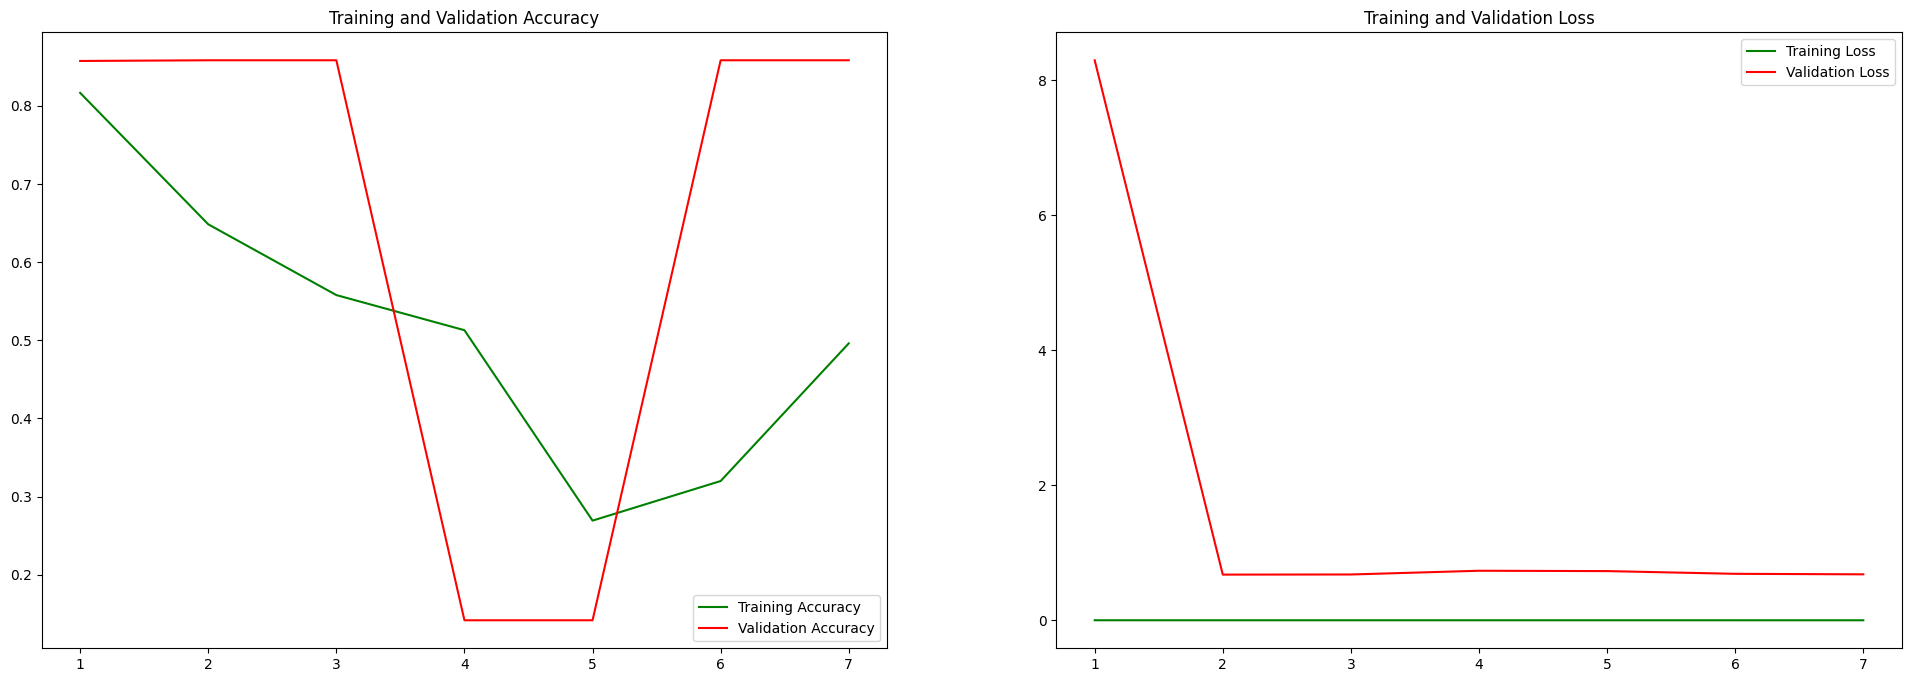

1530/1530 [==============================] - 12s 8ms/step - loss: 0.6757 - binary_accuracy: 0.8701
Validation Binary Accuracy is: 0.86
Testing Binary Accuracy is: 0.87


In [91]:
# Load and Evaluate Model
model_8, history_8 = evaluate_model(model_8_filepath, 
                         history_8_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_8_evaluation.pdf')

4830/4830 [==============================] - 32s 7ms/step


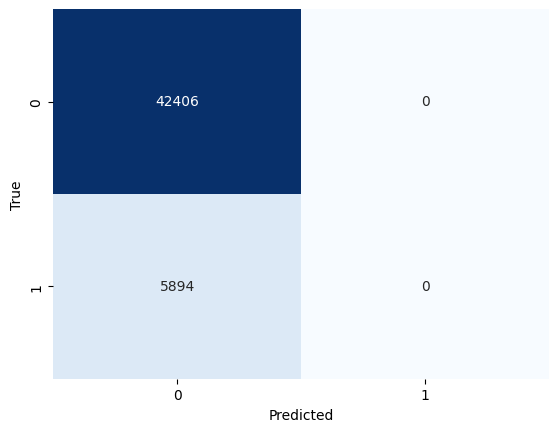

4830/4830 [==============================] - 32s 7ms/step
              precision    recall  f1-score       support
0              0.877971  1.000000  0.935021  42406.000000
1              0.000000  0.000000  0.000000   5894.000000
accuracy       0.877971  0.877971  0.877971      0.877971
macro avg      0.438986  0.500000  0.467510  48300.000000
weighted avg   0.770833  0.877971  0.820921  48300.000000
   6/1470 [..............................] - ETA: 15s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1470/1470 [==============================] - 11s 7ms/step


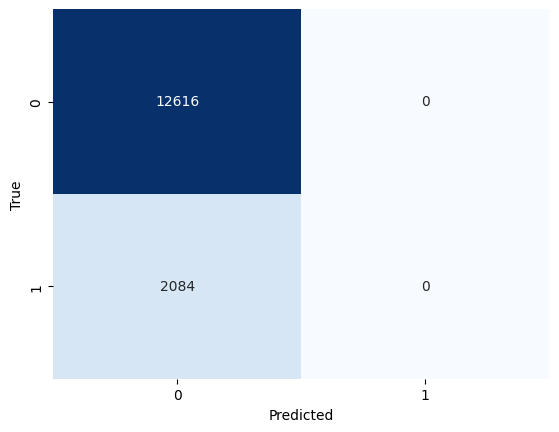

1470/1470 [==============================] - 10s 7ms/step
              precision    recall  f1-score       support
0              0.858231  1.000000  0.923708  12616.000000
1              0.000000  0.000000  0.000000   2084.000000
accuracy       0.858231  0.858231  0.858231      0.858231
macro avg      0.429116  0.500000  0.461854  14700.000000
weighted avg   0.736561  0.858231  0.792755  14700.000000
  17/1530 [..............................] - ETA: 9s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1530/1530 [==============================] - 10s 7ms/step


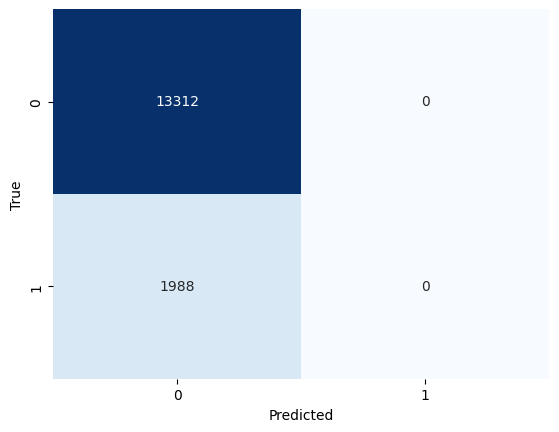

1530/1530 [==============================] - 10s 7ms/step
              precision    recall  f1-score       support
0              0.870065  1.000000  0.930519  13312.000000
1              0.000000  0.000000  0.000000   1988.000000
accuracy       0.870065  0.870065  0.870065      0.870065
macro avg      0.435033  0.500000  0.465259  15300.000000
weighted avg   0.757014  0.870065  0.809612  15300.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
confusion_matrix_plot(model_8, train_gen, save_file='models/evaluate/model_8_train_confusion_matrix.pdf')
classification_report_output(model_8, train_gen, save_file=None)
confusion_matrix_plot(model_8, val_gen, save_file='models/evaluate/model_8_val_confusion_matrix.pdf')
classification_report_output(model_8, val_gen, save_file=None)
confusion_matrix_plot(model_8, test_gen, save_file='models/evaluate/model_8_test_confusion_matrix.pdf')
classification_report_output(model_8, test_gen, save_file=None)

## Model 9
This is a valid implementation of the [TS-Transformer](https://arxiv.org/abs/2103.13790) model using the Keras API in TensorFlow. It consists of a combination of an LSTM layer and several Transformer blocks followed by a fully connected layer to perform binary classification. 

The model is defined using the `build_ts_transformer()` function, which takes in the input shape, number of classes, hyperparameters such as head size, number of heads, feedforward dimension, number of transformer blocks, LSTM units, and MLP units.

### Evaluation
The precision, recall, and F1-score for class 1 (stress) are all 0 in all three sets of data. This indicates that the model did not predict any instances of class 1 correctly. Overall, the model's accuracy is high for classifying non-stress instances (class 0), but it fails to detect instances of stress (class 1).

In [93]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define function to build the TS-Transformer model
def build_ts_transformer(input_shape, n_classes, head_size, num_heads, ff_dim, num_transformer_blocks, lstm_units, mlp_units, dropout=0, mlp_dropout=0):
    # LSTM layer
    inputs = keras.Input(shape=input_shape)
    lstm_out = layers.LSTM(lstm_units, return_sequences=True)(inputs)

    # Transformer blocks
    x = lstm_out
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Flatten and MLP layers
    x = layers.Flatten()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Define the hyperparameters
seq_length = 300
n_classes = 1
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
lstm_units = 64
mlp_units = [128]
mlp_dropout = 0.4
dropout = 0.5
epochs = 20
batch_size = 32
learning_rate = 0.001

# Build the model
model_9 = build_ts_transformer(
    input_shape=(seq_length, train_gen[0][0].shape[2]),
    n_classes=n_classes,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    lstm_units=lstm_units,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

# Compile the model
best_learning_rate = 0.001
model_9.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"]
)

# Print the model summary
model_9.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 300, 20)]    0           []                               
                                                                                                  
 lstm_10 (LSTM)                 (None, 300, 64)      21760       ['input_10[0][0]']               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 300, 64)     128         ['lstm_10[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 300, 64)     265280      ['layer_normalization_16[0]

In [94]:
# Parameters for fitting and saving model training data
epochs = 200
model_9_filepath = 'models/model_9_transformer.keras'
history_9_filepath = 'models/trainHistoryDict/model_9_history.pkl'

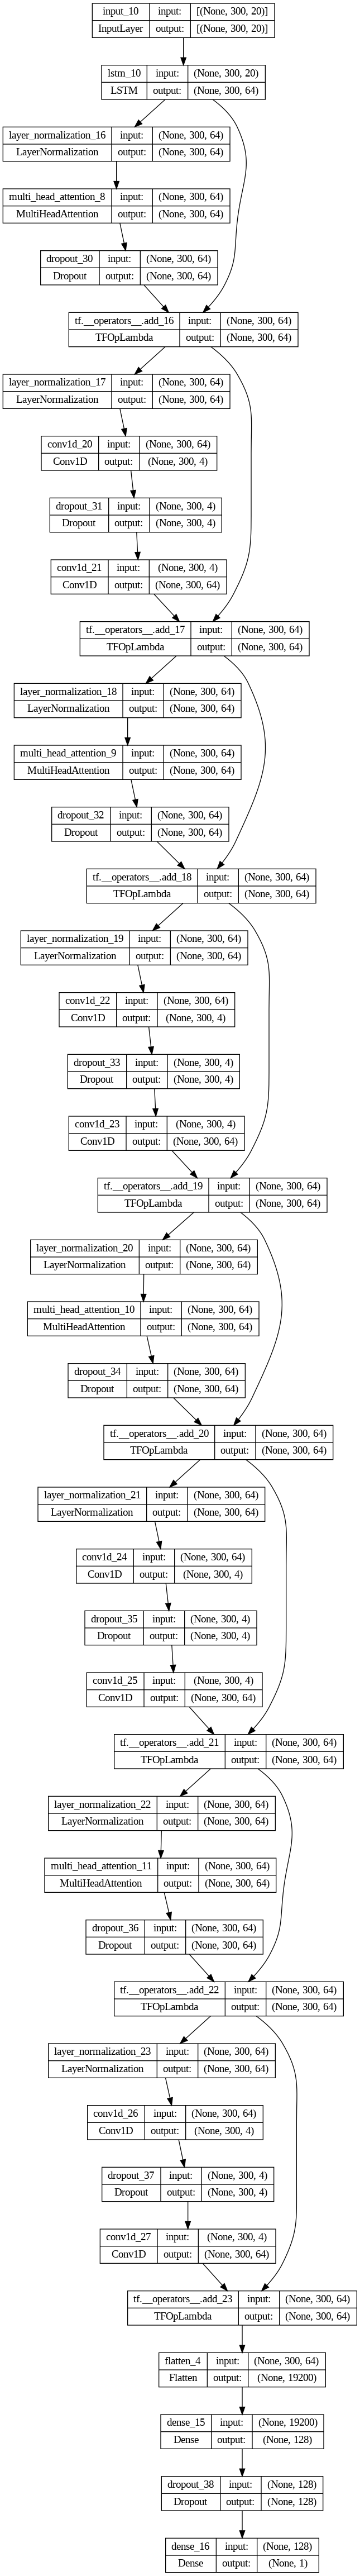

In [95]:
from keras.utils import plot_model

# assuming you have defined a model called "model"
plot_model(model_9, to_file='models/model_8_arch.png', show_shapes=True, show_layer_names=True)

In [96]:
# Fit the model to the training data
history_9 = model_9.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_9_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_9_filepath, 'wb') as file_pi:
    pickle.dump(history_9, file_pi)

Epoch 1/200
4830/4830 [==============================] - 263s 52ms/step - loss: 0.0031 - binary_accuracy: 0.8851 - val_loss: 0.6723 - val_binary_accuracy: 0.8582
Epoch 2/200
4830/4830 [==============================] - 247s 51ms/step - loss: 2.9092e-05 - binary_accuracy: 0.5739 - val_loss: 0.6785 - val_binary_accuracy: 0.8582
Epoch 3/200
4830/4830 [==============================] - 248s 51ms/step - loss: 2.8775e-05 - binary_accuracy: 0.5475 - val_loss: 0.6784 - val_binary_accuracy: 0.8582
Epoch 4/200
4830/4830 [==============================] - 249s 52ms/step - loss: 2.8748e-05 - binary_accuracy: 0.5485 - val_loss: 0.6784 - val_binary_accuracy: 0.8582
Epoch 5/200
4830/4830 [==============================] - 248s 51ms/step - loss: 2.8735e-05 - binary_accuracy: 0.5485 - val_loss: 0.6784 - val_binary_accuracy: 0.8582
Epoch 6/200
4830/4830 [==============================] - 248s 51ms/step - loss: 2.8735e-05 - binary_accuracy: 0.5485 - val_loss: 0.6784 - val_binary_accuracy: 0.8582
Epoch 6:

1470/1470 [==============================] - 27s 17ms/step - loss: 0.6723 - binary_accuracy: 0.8582


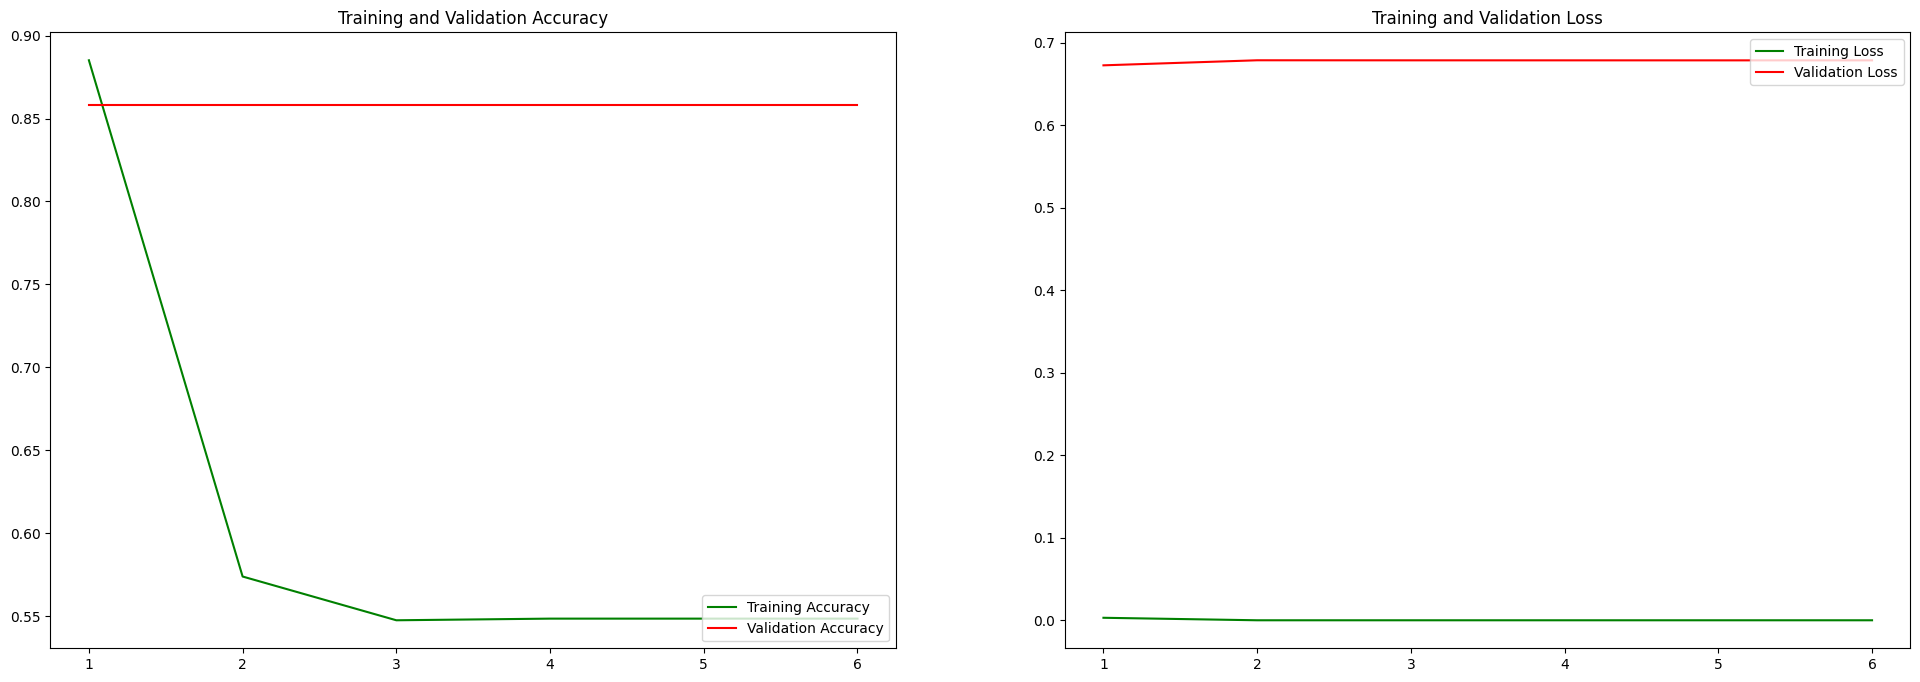

1530/1530 [==============================] - 27s 18ms/step - loss: 0.6716 - binary_accuracy: 0.8701
Validation Binary Accuracy is: 0.86
Testing Binary Accuracy is: 0.87


In [97]:
model_9, history_9 = evaluate_model(model_9_filepath, 
                         history_9_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_9_evaluation.pdf')

4830/4830 [==============================] - 78s 16ms/step


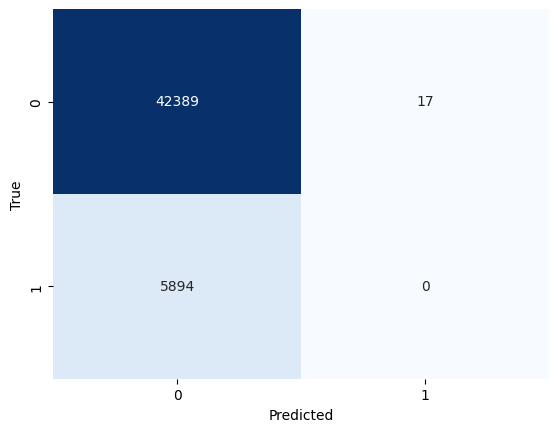

4830/4830 [==============================] - 77s 16ms/step
              precision    recall  f1-score       support
0              0.877928  0.999599  0.934821  42406.000000
1              0.000000  0.000000  0.000000   5894.000000
accuracy       0.877619  0.877619  0.877619      0.877619
macro avg      0.438964  0.499800  0.467411  48300.000000
weighted avg   0.770795  0.877619  0.820746  48300.000000
1470/1470 [==============================] - 23s 16ms/step


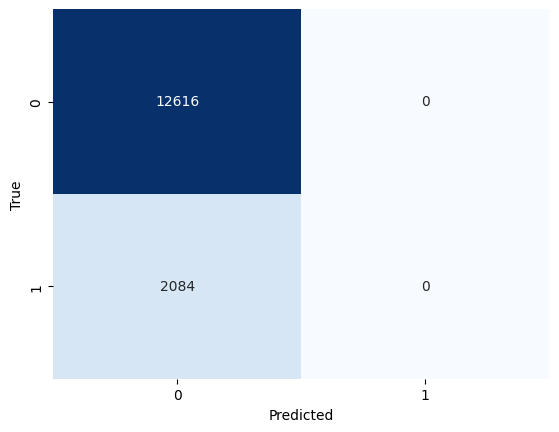

1470/1470 [==============================] - 23s 16ms/step
              precision    recall  f1-score       support
0              0.858231  1.000000  0.923708  12616.000000
1              0.000000  0.000000  0.000000   2084.000000
accuracy       0.858231  0.858231  0.858231      0.858231
macro avg      0.429116  0.500000  0.461854  14700.000000
weighted avg   0.736561  0.858231  0.792755  14700.000000
   9/1530 [..............................] - ETA: 23s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1530/1530 [==============================] - 24s 16ms/step


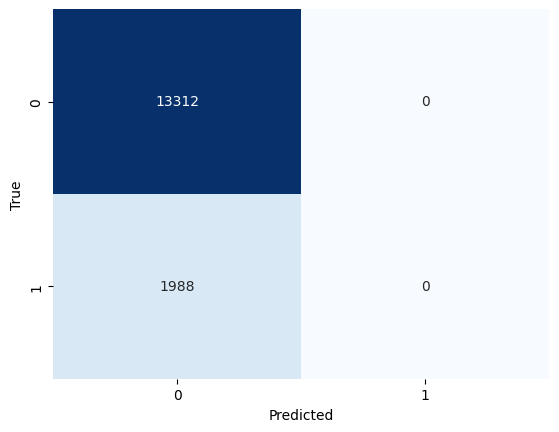

1530/1530 [==============================] - 24s 16ms/step
              precision    recall  f1-score       support
0              0.870065  1.000000  0.930519  13312.000000
1              0.000000  0.000000  0.000000   1988.000000
accuracy       0.870065  0.870065  0.870065      0.870065
macro avg      0.435033  0.500000  0.465259  15300.000000
weighted avg   0.757014  0.870065  0.809612  15300.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
confusion_matrix_plot(model_9, train_gen, save_file='models/evaluate/model_9_train_confusion_matrix.pdf')
classification_report_output(model_9, train_gen, save_file=None)
confusion_matrix_plot(model_9, val_gen, save_file='models/evaluate/model_9_val_confusion_matrix.pdf')
classification_report_output(model_9, val_gen, save_file=None)
confusion_matrix_plot(model_9, test_gen, save_file='models/evaluate/model_9_test_confusion_matrix.pdf')
classification_report_output(model_9, test_gen, save_file=None)

## Model 10 XGBoost
XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm that is widely used for various types of predictive modeling tasks, including regression and classification. It is known for its ability to deliver high predictive accuracy and handle complex relationships in the data.

XGBoost Algorithm: XGBoost is an ensemble learning method that combines the predictions of multiple weak prediction models (often decision trees) to create a strong predictive model. It uses a boosting technique, where each subsequent model focuses on correcting the mistakes made by the previous models. This iterative process helps XGBoost to continually improve its predictions.

Wearable device data often contains a large number of features and can have complex relationships between them. XGBoost is effective at capturing these intricate relationships and identifying important features for accurate predictions. It can handle a mix of continuous and categorical features, making it versatile for various types of wearable device data.

XGBoost provides a measure of feature importance, which can help you understand which features from the wearable device data are most influential in predicting stress levels. This information can guide feature selection and potentially lead to insights about the underlying factors contributing to stress.

### Evaluation

The XGBoost model performs well overall. The model performs well in terms of accuracy and precision for both the validation and testing sets. However, it exhibits a lower recall and F1-score for the positive class (class 1), indicating that it may have difficulty detecting instances of stress.

Overall, the model achieves high accuracy on the training set and decent accuracy on the validation and testing sets. However, it appears that the model struggles to correctly classify instances of class 1 (stressful state) compared to class 0 (non-stressful state), as indicated by lower precision, recall, and F1-score for class 1.

#### Feature Importance
The XGBoost feature importance results indicate that physiological measurements related to heart rate, electrodermal activity, respiration rate, and temperature are important factors for predicting stress using the XGBoost model. The longer-term averages and standard deviations (300-second window) seem to carry more weight in the prediction compared to the shorter-term (60-second window) features.

In [99]:
# XGBoost and Random Forests
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extract features and labels from the TimeseriesGenerator
X_train = np.concatenate([batch[0] for batch in train_gen])
y_train = np.concatenate([batch[1] for batch in train_gen])

X_val = np.concatenate([batch[0] for batch in val_gen])
y_val = np.concatenate([batch[1] for batch in val_gen])

X_test = np.concatenate([batch[0] for batch in test_gen])
y_test = np.concatenate([batch[1] for batch in test_gen])

# Reshape the data into a 2D format
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [100]:
X_train_2d.shape

(48300, 6000)

In [101]:
len(X_train)

48300

In [102]:
X_train = train_df.drop(['label', 'subject'], axis=1)
y_train = train_df['label']

X_val = val_df.drop(['label', 'subject'], axis=1)
y_val = val_df['label']

X_test = test_df.drop(['label', 'subject'], axis=1)
y_test = test_df['label']

In [103]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'tree_method': ['gpu_hist'],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5]
}

#Train an XGBoost model:
xgb_model = XGBClassifier(random_state=42,
                          class_weight = class_weights_dict)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    error_score='raise',
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available GPU cores
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)




Fitting 5 folds for each of 27 candidates, totalling 135 fits
[02:58:01] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None,
                                     class_weight={0: 2.3252569408919687e-05,
                                                   1: 0.00016966406515100103},
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, g...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 6, 9], 'n_estimators': [50, 100, 150],
                         'tree_method': ['gpu_hist']},
             scoring='accuracy', verbose=3)

In [104]:
# Print the best hyperparameters and the corresponding validation accuracy
y_train_pred = grid_search.predict(X_train)
y_val_pred = grid_search.predict(X_val)
y_test_pred = grid_search.predict(X_test)
print("Best hyperparameters:", grid_search.best_params_)
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

# Print confusion matrix for testing set
print("Confusion matrix (testing set):\n", confusion_matrix(y_test, y_test_pred))

# Print classification report for testing set
print("Classification report (testing set):\n", classification_report(y_test, y_test_pred))

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'tree_method': 'gpu_hist'}
Train accuracy: 0.9805316973415132
Validation accuracy: 0.908954248366013
Confusion matrix (training set):
 [[42722   284]
 [  668  5226]]
Classification report (training set):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     43006
           1       0.95      0.89      0.92      5894

    accuracy                           0.98     48900
   macro avg       0.97      0.94      0.95     48900
weighted avg       0.98      0.98      0.98     48900

Confusion matrix (validation set):
 [[12846   370]
 [ 1023  1061]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     13216
           1       0.74      0.51      0.60      2084

    accuracy                           0.91     15300
   macro avg       0.83      0.74      0.78     15300
weighte

In [105]:
import pandas as pd
import numpy as np

# Get the booster object
booster = grid_search.best_estimator_.get_booster()

# Get the feature importance scores
feature_importances = booster.get_score(importance_type="weight")

# Create a dataframe to store the feature importance scores
fi_df = pd.DataFrame({'feature': list(feature_importances.keys()), 'importance': list(feature_importances.values())})

# Sort the dataframe by feature importance scores in descending order
fi_df = fi_df.sort_values(by='importance', ascending=False)

# Print the top ten most important features
print(fi_df.head(10))

                feature  importance
5     RSP_Rate_std_300s        59.0
10   ECG_Rate_mean_300s        50.0
8     ECG_Rate_mean_60s        43.0
6    EDA_Phasic_std_60s        39.0
15        Temp_std_300s        34.0
7   EDA_Phasic_std_300s        31.0
12        Temp_mean_60s        15.0
13         Temp_std_60s        15.0
14       Temp_mean_300s        14.0
4      RSP_Rate_std_60s         9.0


## Model 11
The Random Forest model is a powerful machine learning algorithm that can be used for classification tasks, such as forecasting stress using wearable device data. Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. Each decision tree is built independently on different subsets of the data, and the final prediction is made by aggregating the predictions of all individual trees. This ensemble approach helps improve the model's accuracy and robustness.



In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
}

# Create a RandomForestClassifier object
rf_model = RandomForestClassifier(random_state=42,
                                  class_weight = class_weights_dict)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available cores
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 2.3252569408919687e-05,
                                                            1: 0.00016966406515100103},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=3)

In [107]:
# Print the best hyperparameters and the corresponding validation accuracy
y_train_pred = grid_search.predict(X_train)
y_val_pred = grid_search.predict(X_val)
y_test_pred = grid_search.predict(X_test)
print("Best hyperparameters:", grid_search.best_params_)
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

# Print confusion matrix for testing set
print("Confusion matrix (testing set):\n", confusion_matrix(y_test, y_test_pred))

# Print classification report for testing set
print("Classification report (testing set):\n", classification_report(y_test, y_test_pred))

Best hyperparameters: {'max_depth': 6, 'n_estimators': 100}
Train accuracy: 0.94640081799591
Validation accuracy: 0.9032679738562092
Confusion matrix (training set):
 [[40385  2621]
 [    0  5894]]
Classification report (training set):
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     43006
           1       0.69      1.00      0.82      5894

    accuracy                           0.95     48900
   macro avg       0.85      0.97      0.89     48900
weighted avg       0.96      0.95      0.95     48900

Confusion matrix (validation set):
 [[12254   962]
 [  518  1566]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.96      0.93      0.94     13216
           1       0.62      0.75      0.68      2084

    accuracy                           0.90     15300
   macro avg       0.79      0.84      0.81     15300
weighted avg       0.91      0.90      0.91     15300

C

# Model Evaluation

## Metrics used
The purpose of this analysis is to be able to forecast a stressful state for a user of our wearable device hardware. In this case it is important to avoid false negative predictions while limiting false positives.

Precision, also known as the Positive Predictive Value (PPV), measures the accuracy of positive predictions made by a classifier. It is the ratio of true positives to the sum of true positives and false positives. Precision focuses on the performance of the classifier when it predicts the positive class.

## Model Results

| Model  | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-score (Class 1) |
|--------|----------|---------------------|------------------|--------------------|
| Model 0|   0.905  |         0.661           |        0.554            |       0.603          |
| Model 1|   0.829  |         0.402           |        0.642            |       0.494          |
| Model 2|   0.790  |         0.343           |        0.676            |       0.455          |
| Model 3|   0.647  |         0.130           |        0.303            |       0.182          |
| Model 4|   0.870  |         0.000           |        0.000            |       0.000          |
| Model 5|   0.870  |         0.000           |        0.000            |       0.000          |
| Model 6|   0.846  |         0.073           |        0.016            |       0.026          |
| Model 7|   0.130  |         0.130           |        1.000            |       0.230          |
| Model 8|   0.870  |         0.000           |        0.000            |       0.000          |
| Model 9|   0.870  |         0.000           |        0.000            |       0.000          |
| Model 10|   0.910 |         0.630           |        0.670            |       0.650          |
| Model 11|   0.840 |         0.420           |        0.700            |       0.530          |

## Conclusions
Based on the F1-score for the stress case, the best models to forecast if a person will be in a stressful state in the next 5 minutes is with model 10, the baseline model 0, and model 11.

Model 10 is an XGBoost model. It has a F1-score of 0.65 and precision of 0.63. This model's metric results is very similar to the baseline fully connected neural network model that had a F1-score of 0.60 and precision of 0.66. A higher F1-score indicates that the model has both good precision and recall, meaning it is effective in making accurate positive predictions while minimizing false positives and false negatives.

# Summary
- A dataset of 15 subjects recorded in an neutral and stressful state for 90 minutes was used.
- The dataset was recorded between 700 to 4 Hz. This was downsampled to 1 Hz
- Model 10 using XGBoost was the best model followed by the baseline model
- These models are only slightly better than guessing the stress or normal state for each instance
- A larger dataset using more subjects would improve the F1-score
- The most important features accourding to model 10 is mean heart rate over the previous 5 minutes and 1 minute.

# Recommendations

After you analyzed the model, which model is best
How can you interpret the model to make extra recommendations
